In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from tensorflow import keras
from sklearn.metrics import matthews_corrcoef, accuracy_score, root_mean_squared_error, mean_squared_error, mean_absolute_error, precision_score, confusion_matrix, multilabel_confusion_matrix, classification_report, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm
import time
from sklearn.preprocessing import StandardScaler, LabelEncoder
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import gc
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import pickle

2025-04-13 21:00:16.353435: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744567216.368857  212282 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744567216.373488  212282 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744567216.385624  212282 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744567216.385642  212282 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744567216.385643  212282 computation_placer.cc:177] computation placer alr

# Functions

In [2]:
def visualize_CM(matrix):
    """
    Visualize Correlation Matrix
    """
    sns.heatmap(matrix,annot=True)

def result_plot(_dict, name, folder, model_name):
    """
    Plot results for multiclass classification
    """
    attacks = {}
    higher = ["F1", "Accuracy", "Precision", "Recall", "MCC", "precision", "recall", "f1-score", "support", 'Benign', 'Bruteforce', 'DDoS', 'DoS', 'Mirai', 'Recon', 'Spoofing',
       'Web']
    fig, ax = plt.subplots(figsize=(10,10))
    if name in higher:
        tmp = sorted(_dict.items(), key = lambda x:x[1])
    else:
        tmp = sorted(_dict.items(), key = lambda x:x[1], reverse=True)
    for x in tmp:
        attacks[x[0]] = x[1]
    ax.bar(attacks.keys(), attacks.values())
    rects = ax.patches
    results = [i for i in attacks.values()]
    labels = [f"{results[i]:.6f}" for i in range(len(rects))]
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height, label, ha="center", va="bottom"
        )
    if name in higher:
        name = name.capitalize()
        ax.set_title(f'{name} (higher is better)', fontsize=16, fontweight="bold")
    else:
        ax.set_title(f'{name} (lower is better)', fontsize=16, fontweight="bold")
    ax.set_xlabel(f'{name}')
    ax.set_ylabel('Score')
    ax.grid(which='Major', axis='both')
    ax.set_axisbelow(True)
    if (model_name == ""):
        plt.savefig(f"images/results/{folder}/1000/{name}.png")
    else:
        plt.savefig(f"images/results/{folder}/1000/{name}_{model_name}.png")

def plot_mc(y_pred, y_test, model_name, mc_results = {}):
    """
    Plots Precision, Recall and F1 scores for each class in multiclass classification
    """
    cr = classification_report(y_pred, y_test, output_dict=True)
    for key, name in cr.items():
        if key not in ['accuracy', 'macro avg', 'weighted avg'] and int(key) in attack_dict:
            mc_results[attack_dict[int(key)]] = cr[key]
    mc_results = pd.DataFrame(mc_results).drop(['support'], axis = 0)
    print(mc_results)
    for key in mc_results.keys():
        result_plot(mc_results[key], key, "multiclass_by_class", model_name)

# Load data

In [3]:
data = pd.read_csv('data/CIC_IoT2023/custom/multiclass_classification_data_60000.csv')

In [4]:
data = data.drop(['Unnamed: 0', 'label', 'Class'], axis=1)

In [5]:
data.head()

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,Attack Type
0,0.0,0.0,0.99,65.27,1.232415,1.232415,0.0,0.0,0.0,0.0,...,0.617394,42.18,8.312856e+07,9.5,9.184764,0.874489,2.990124,0.13,141.55,DDoS
1,0.0,54.0,6.00,64.00,31.840037,31.840037,0.0,0.0,1.0,0.0,...,0.000000,54.00,8.309343e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,DDoS
2,0.0,0.0,0.99,63.36,2.481472,2.481472,0.0,0.0,0.0,0.0,...,0.617394,42.18,8.314964e+07,9.5,9.184764,0.874489,2.990124,0.13,141.55,DDoS
3,0.0,54.0,6.00,64.00,4.499163,4.499163,0.0,0.0,0.0,0.0,...,0.000000,54.00,8.333215e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,DDoS
4,0.0,54.0,6.00,64.00,15.849033,15.849033,0.0,0.0,0.0,0.0,...,0.000000,54.00,8.307156e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,DDoS


In [6]:
data.tail()

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,Attack Type
397888,3066.037345,10267.5,11.5,130.5,1.029689,1.029689,0.0,0.0,0.0,0.0,...,48.073719,175.9,4.020541e-02,5.5,15.420603,67.986505,3619.117272,0.9,38.5,Bruteforce
397889,343.000496,106722.4,12.6,96.3,3.483237,3.483237,0.0,0.0,0.0,0.0,...,53.837593,81.8,1.666014e+08,13.5,13.133269,76.311509,2921.188688,1.0,244.6,Bruteforce
397890,199.262425,16583.6,9.3,118.9,0.319272,0.319272,0.0,0.0,0.0,0.0,...,71.998962,101.7,2.843370e-02,5.5,14.011221,101.821908,7002.672673,0.9,38.5,Bruteforce
397891,177.979327,29709.7,9.3,93.8,1.760932,1.760932,0.0,0.0,0.0,0.0,...,66.139131,94.8,1.666014e+08,13.5,14.883212,93.714094,4411.596919,1.0,244.6,Bruteforce
397892,299.487685,38503.2,15.3,57.6,2.423920,2.423920,0.0,0.0,0.0,0.0,...,77.932213,137.4,1.224859e-02,5.5,14.286196,110.212793,9866.644535,0.9,38.5,Bruteforce


In [7]:
X = data.drop(['Attack Type'], axis = 1)
y = data['Attack Type']

In [8]:
X.head()

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,AVG,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight
0,0.0,0.0,0.99,65.27,1.232415,1.232415,0.0,0.0,0.0,0.0,...,42.180879,0.617394,42.18,8.312856e+07,9.5,9.184764,0.874489,2.990124,0.13,141.55
1,0.0,54.0,6.00,64.00,31.840037,31.840037,0.0,0.0,1.0,0.0,...,54.000000,0.000000,54.00,8.309343e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55
2,0.0,0.0,0.99,63.36,2.481472,2.481472,0.0,0.0,0.0,0.0,...,42.180879,0.617394,42.18,8.314964e+07,9.5,9.184764,0.874489,2.990124,0.13,141.55
3,0.0,54.0,6.00,64.00,4.499163,4.499163,0.0,0.0,0.0,0.0,...,54.000000,0.000000,54.00,8.333215e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55
4,0.0,54.0,6.00,64.00,15.849033,15.849033,0.0,0.0,0.0,0.0,...,54.000000,0.000000,54.00,8.307156e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55


In [9]:
y

0               DDoS
1               DDoS
2               DDoS
3               DDoS
4               DDoS
             ...    
397888    Bruteforce
397889    Bruteforce
397890    Bruteforce
397891    Bruteforce
397892    Bruteforce
Name: Attack Type, Length: 397893, dtype: object

In [10]:
le = LabelEncoder()

data['Attack Number'] = le.fit_transform(y)
y = data['Attack Number']

In [11]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [12]:
attack_dict = {}
encoded_values = data['Attack Number'].unique()
for val in sorted(encoded_values):
    attack_dict[val] = le.inverse_transform([val])[0]
    print(f"{val}: {le.inverse_transform([val])[0]}")

0: Benign
1: Bruteforce
2: DDoS
3: DoS
4: Mirai
5: Recon
6: Spoofing
7: Web


# Multiclass Classification

In [13]:
results_dict = {}

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((338209, 46), (338209,), (59684, 46), (59684,))

# K Nearest Neighbour

In [15]:
%%time

start = time.time()

knn_clf = KNeighborsClassifier(n_jobs=8)
knn_clf.fit(X_train, y_train)
y_pred = knn_clf.predict(X_test)

end = time.time()

KNN_time = end - start

CPU times: user 1min 40s, sys: 39 ms, total: 1min 40s
Wall time: 25.5 s


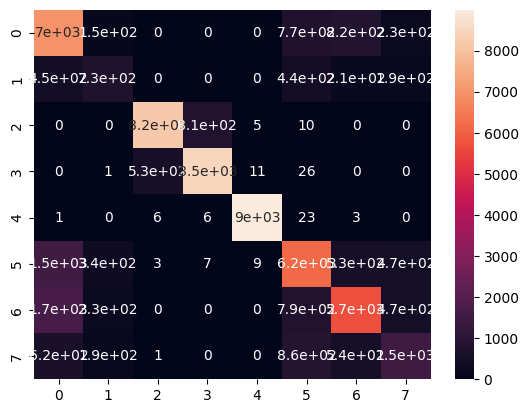

In [16]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [17]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred)
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [18]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, KNN_time]
results_dict["kNN"] = results

In [19]:
results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])

In [20]:
results_df

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Time
kNN,0.78232,0.782244,0.779781,0.78232,0.746857,0.792775,3.972287,1.99306,25.503519


             Benign  Bruteforce      DDoS       DoS     Mirai     Recon  \
precision  0.779680    0.362599  0.908331  0.937128  0.995682  0.679577   
recall     0.618224    0.443568  0.937680  0.911882  0.997228  0.679204   
f1-score   0.689628    0.399017  0.922772  0.924332  0.996455  0.679391   

           Spoofing       Web  
precision  0.641295  0.401568  
recall     0.730320  0.520687  
f1-score   0.682918  0.453435  


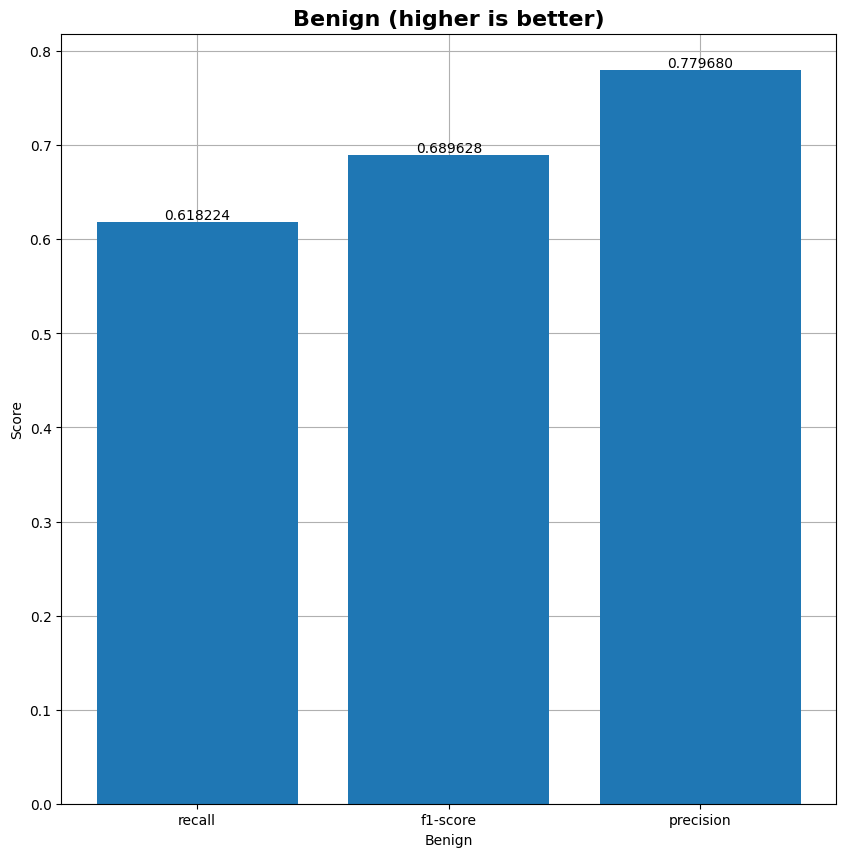

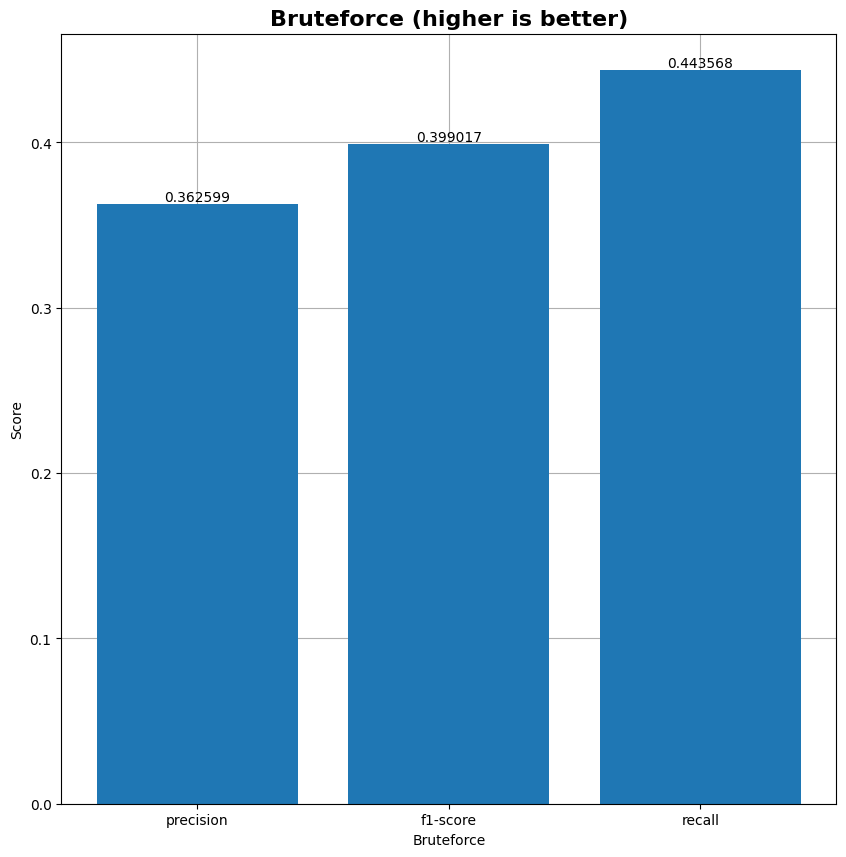

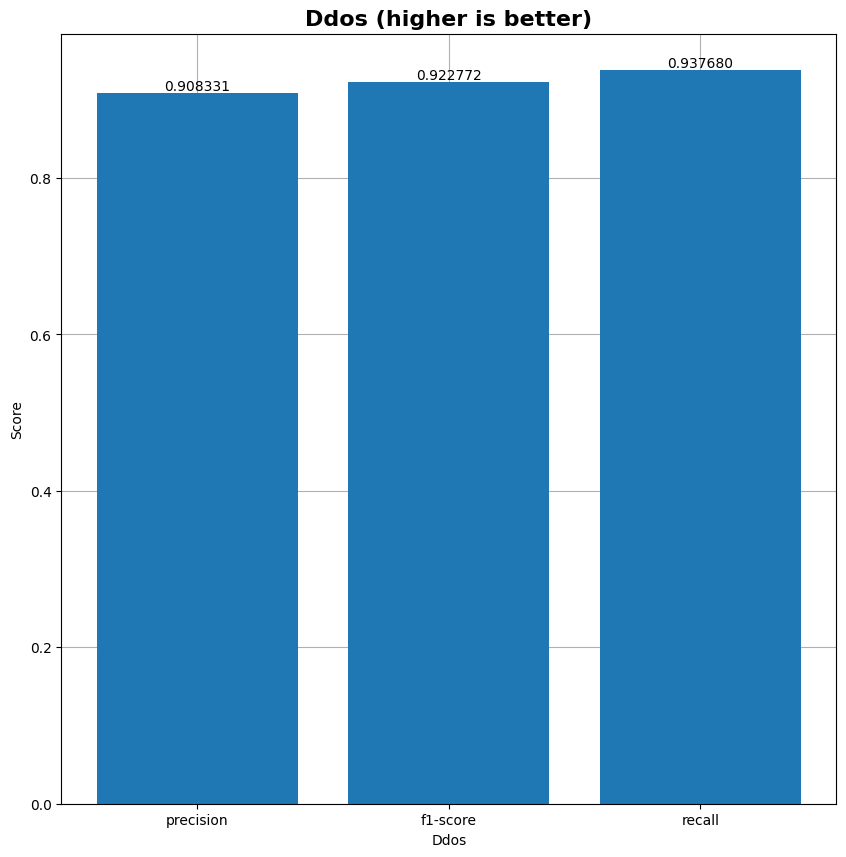

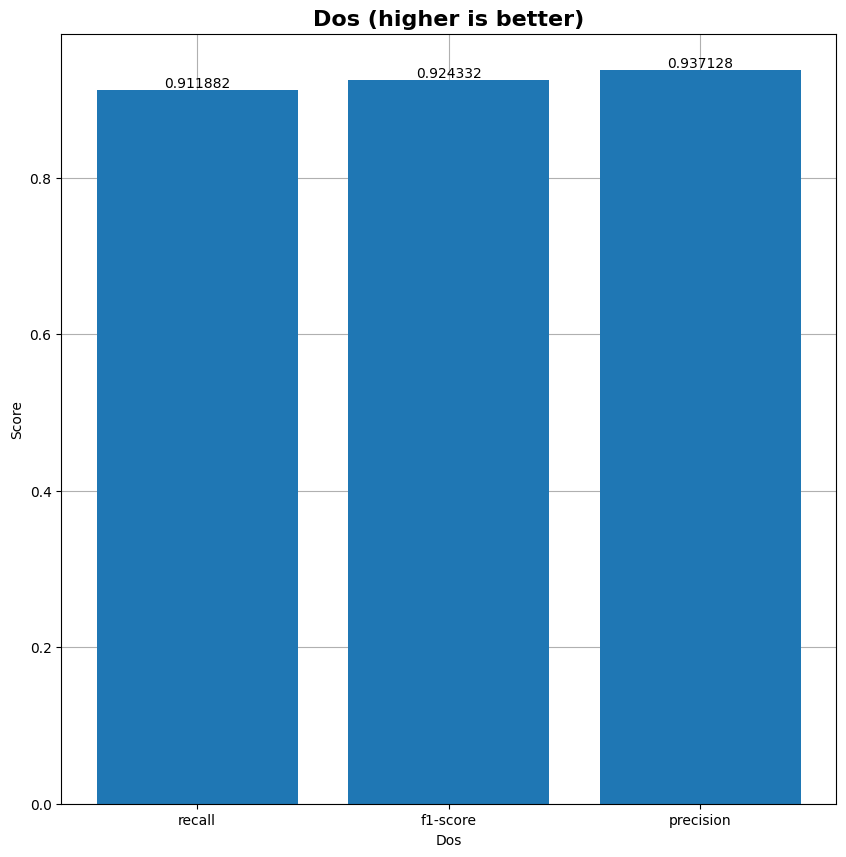

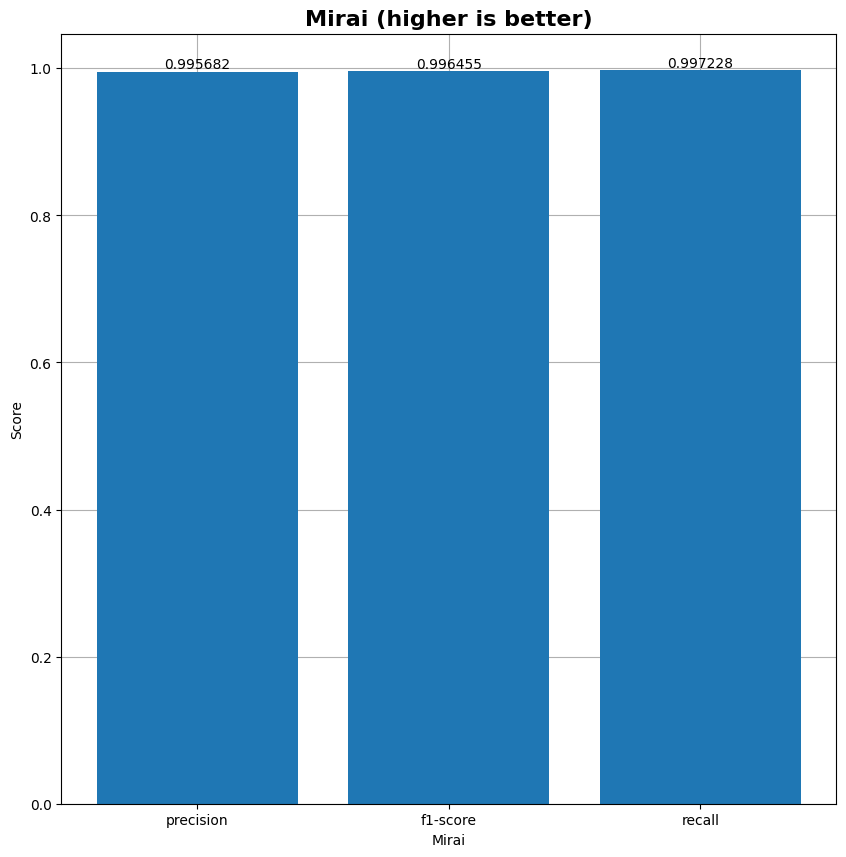

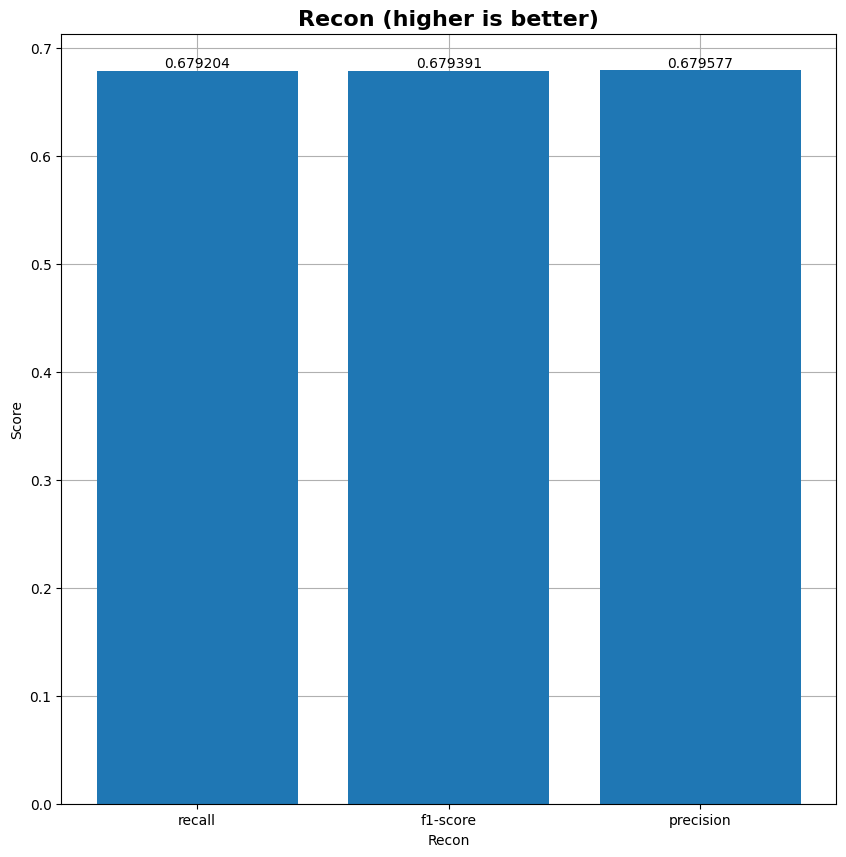

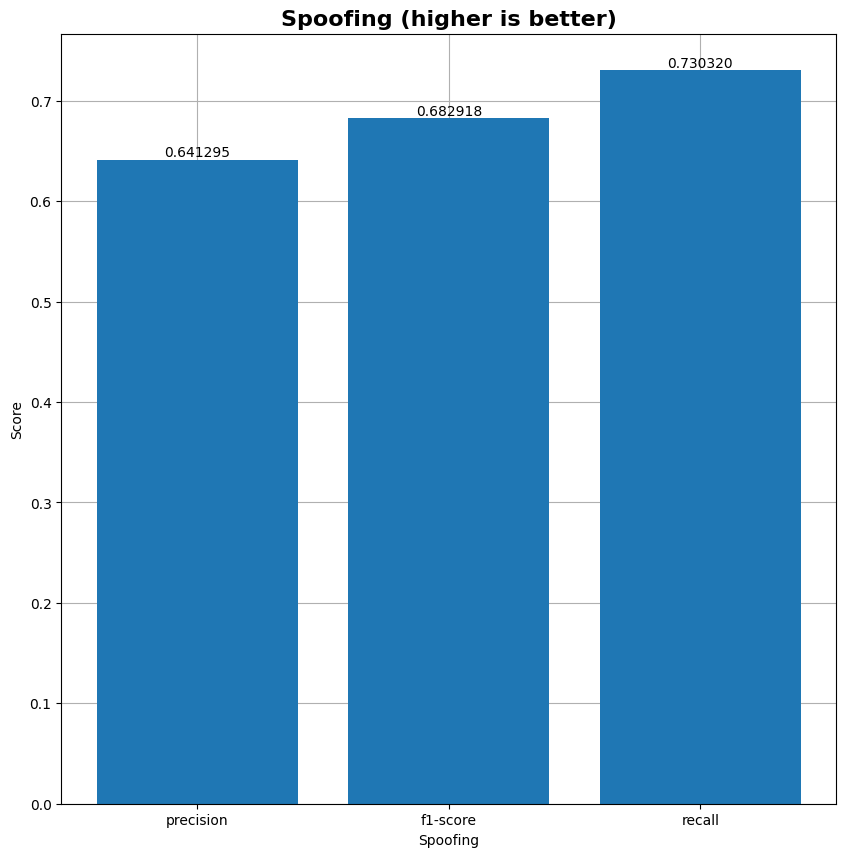

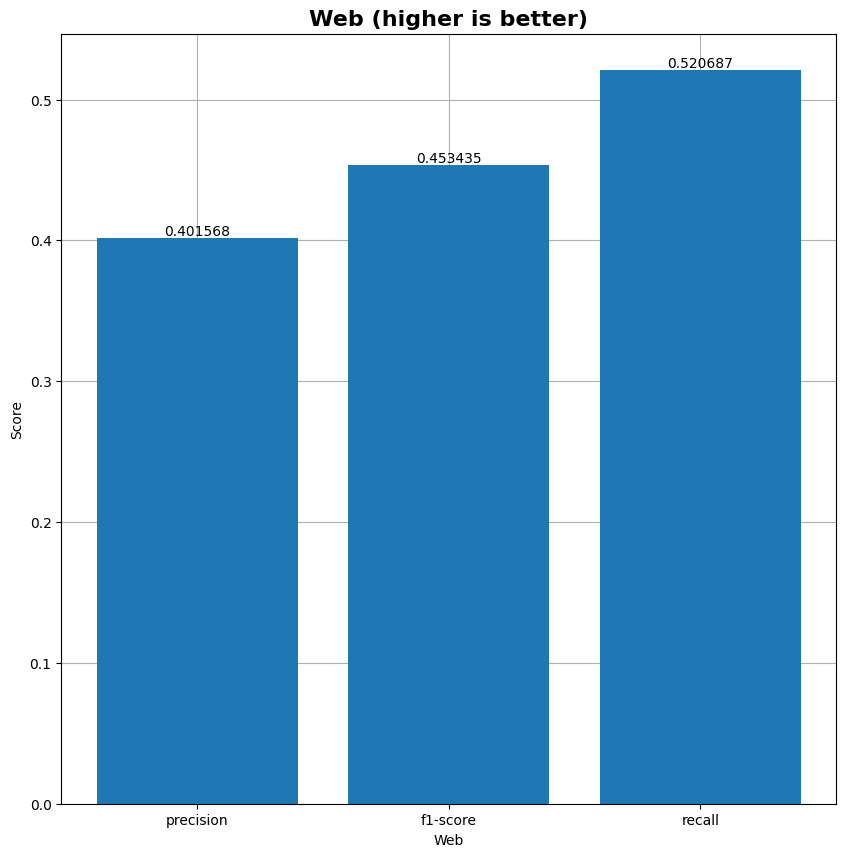

In [21]:
plot_mc(y_pred, y_test, "kNN")

In [22]:
model_name = "kNN_60000.sav"
pickle.dump(knn_clf, open(model_name, 'wb'))

# Random Forest

In [23]:
%%time

start = time.time()

rf_clf = RandomForestClassifier(n_jobs=8)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)

end = time.time()

RF_time = end - start

CPU times: user 2min 36s, sys: 596 ms, total: 2min 37s
Wall time: 20.7 s


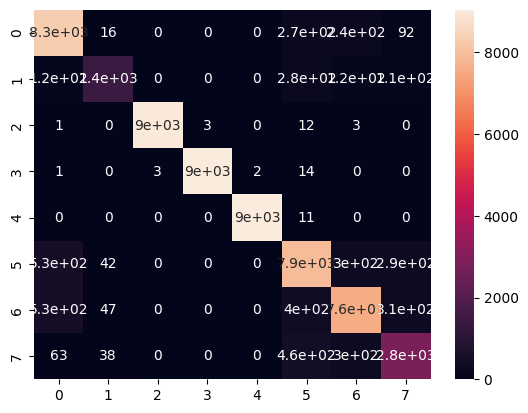

In [24]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [25]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred)
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [26]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, RF_time]
results_dict["RF"] = results

In [27]:
results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])

In [28]:
results_df

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Time
kNN,0.782320,0.782244,0.779781,0.782320,0.746857,0.792775,3.972287,1.993060,25.503519
RF,0.922827,0.923312,0.922340,0.922827,0.910142,0.263370,1.246046,1.116264,20.739691


             Benign  Bruteforce      DDoS       DoS     Mirai     Recon  \
precision  0.931297    0.689980  0.997884  0.997794  0.998782  0.871809   
recall     0.870334    0.906780  0.999665  0.999668  0.999778  0.845571   
f1-score   0.899784    0.783662  0.998774  0.998730  0.999280  0.858490   

           Spoofing       Web  
precision  0.854871  0.766090  
recall     0.886459  0.780441  
f1-score   0.870379  0.773199  


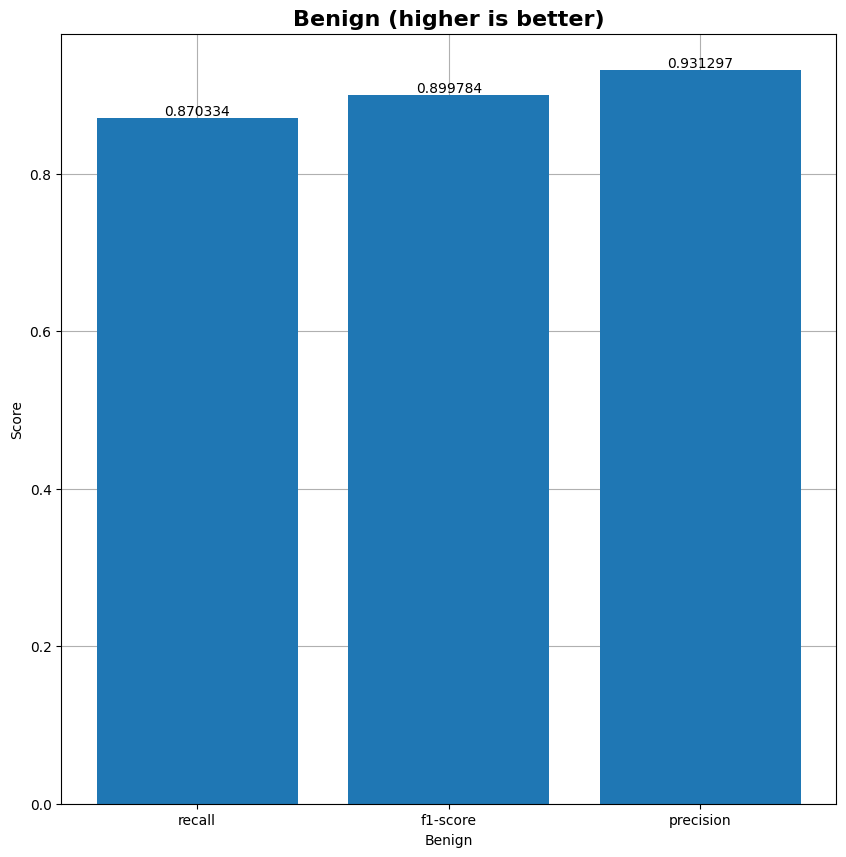

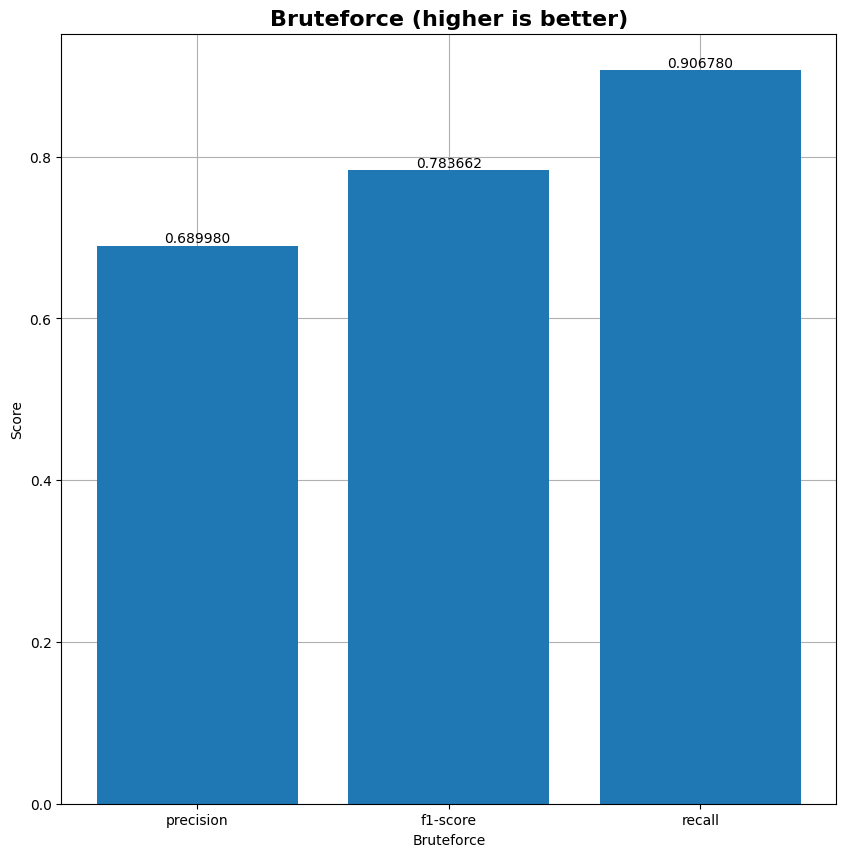

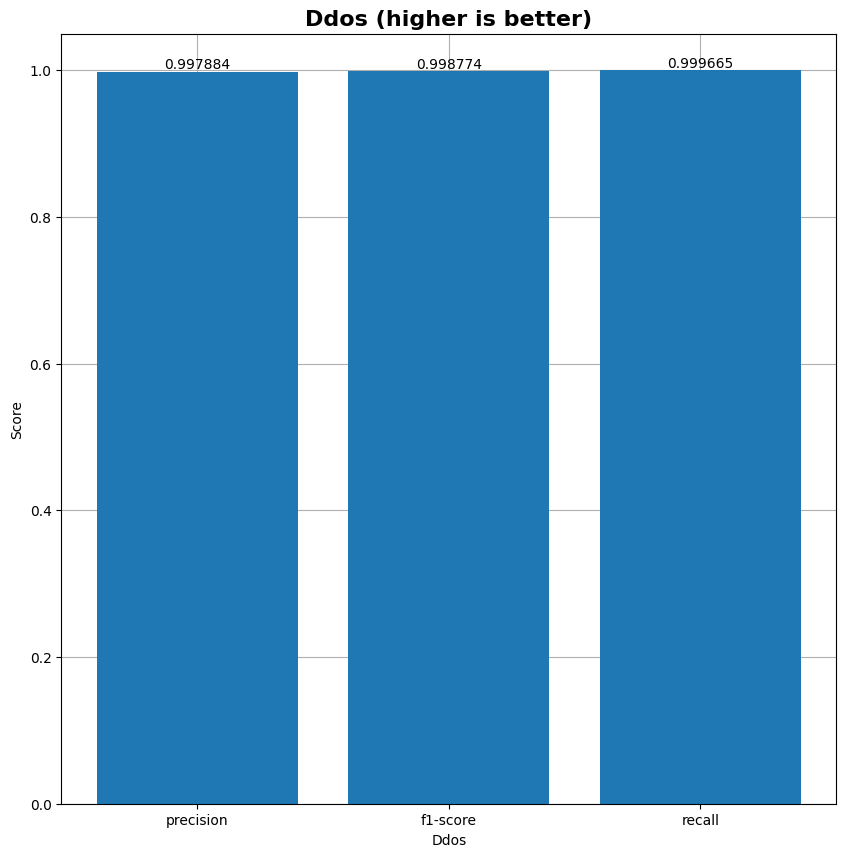

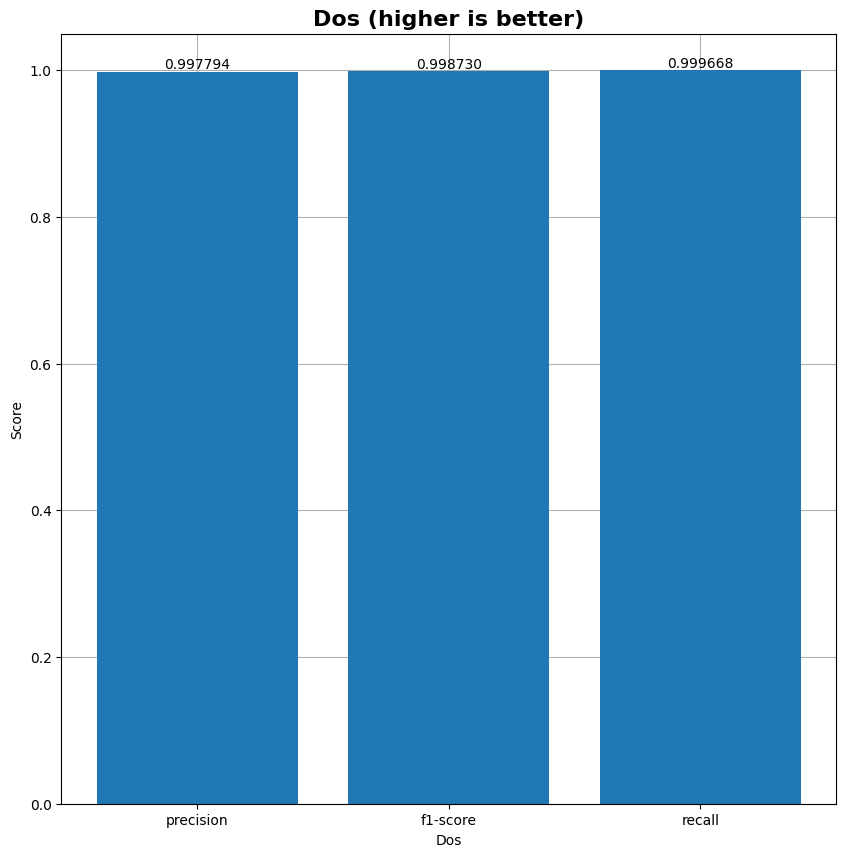

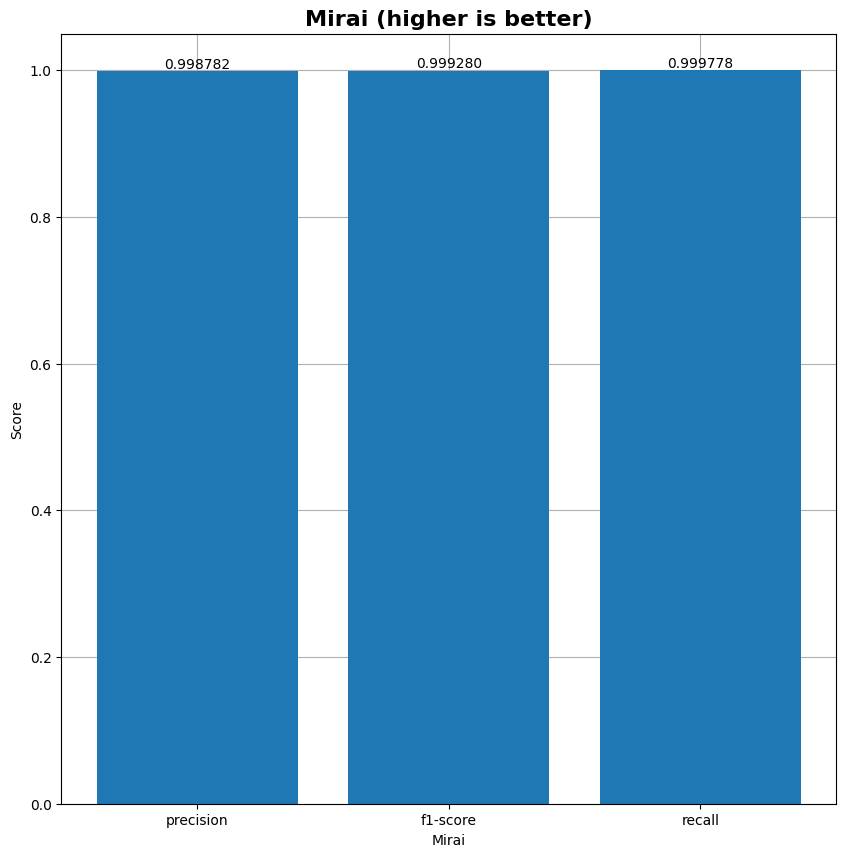

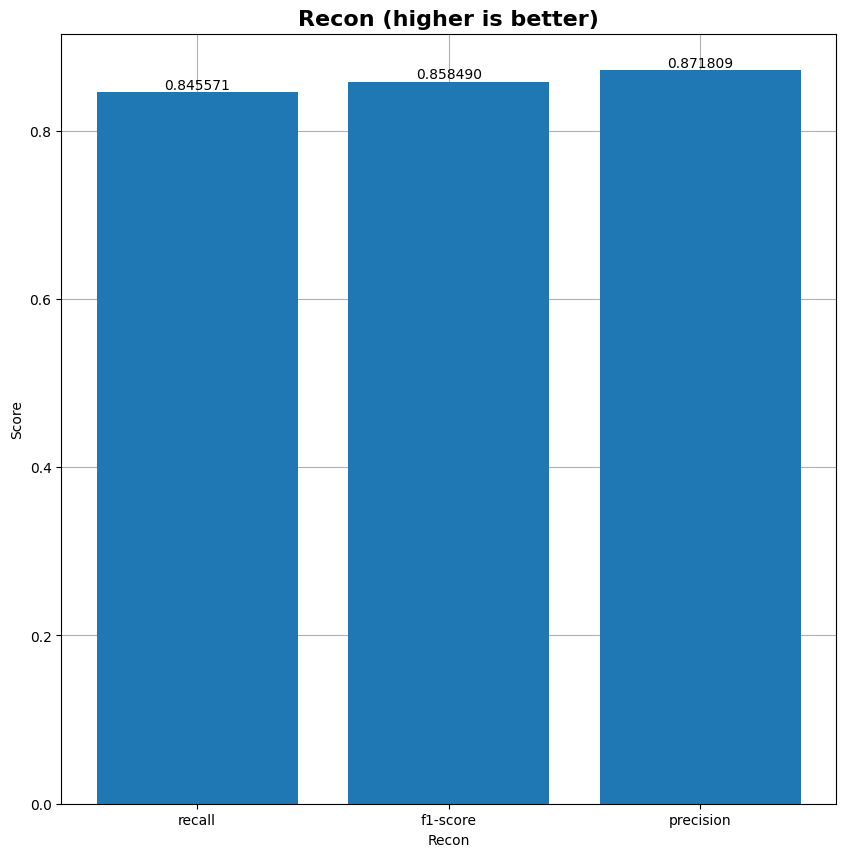

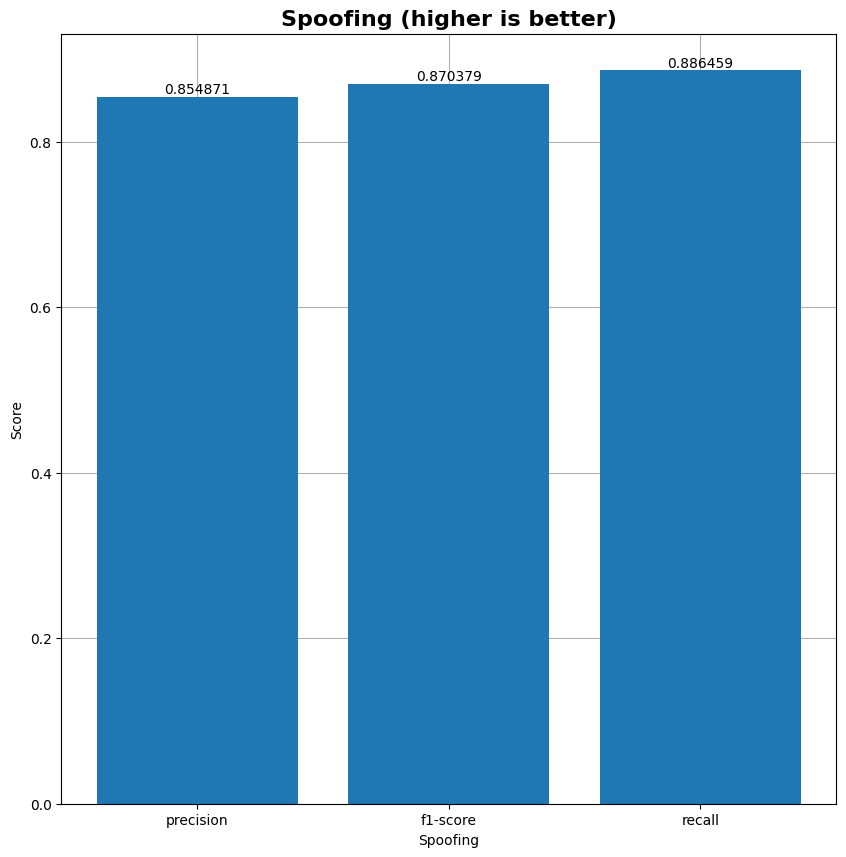

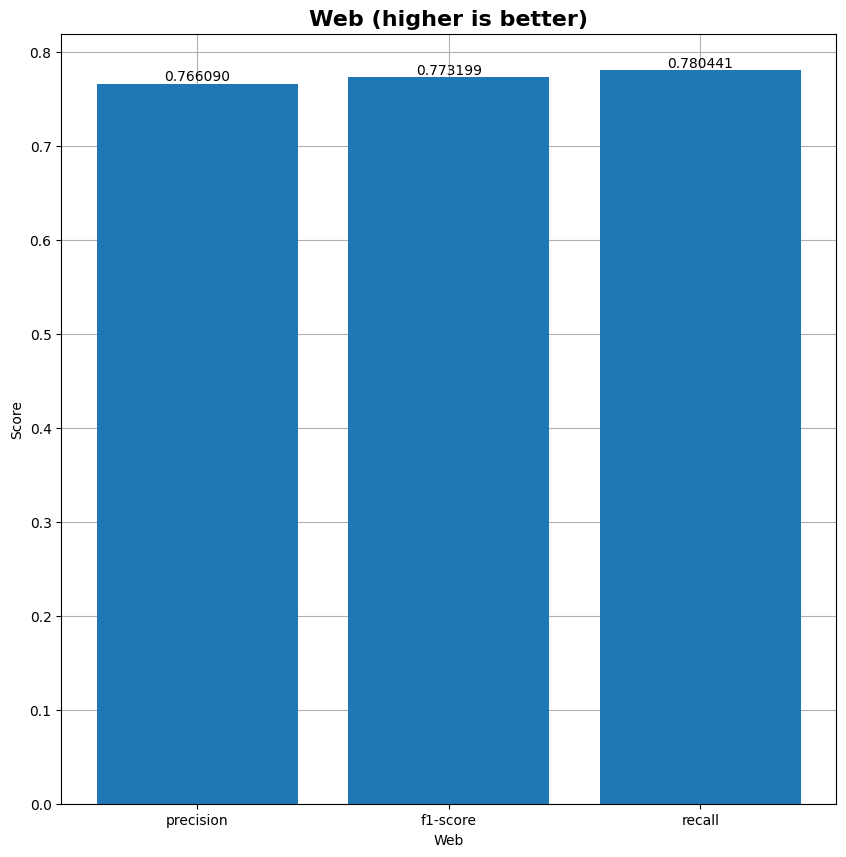

In [29]:
plot_mc(y_pred, y_test, "RF")

In [30]:
model_name = "RF_60000.sav"
pickle.dump(rf_clf, open(model_name, 'wb'))

# XGBoost

In [31]:
%%time

start = time.time()

xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)

end = time.time()

XGB_time = end - start

CPU times: user 1min 33s, sys: 334 ms, total: 1min 33s
Wall time: 12.1 s


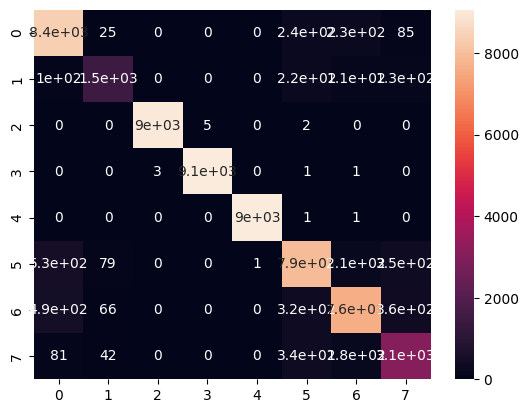

In [32]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [33]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [34]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, XGB_time]
results_dict["XGBoost"] = results

In [35]:
results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])

In [36]:
results_df

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Time
kNN,0.782320,0.782244,0.779781,0.782320,0.746857,0.792775,3.972287,1.993060,25.503519
RF,0.922827,0.923312,0.922340,0.922827,0.910142,0.263370,1.246046,1.116264,20.739691
XGBoost,0.929629,0.930481,0.929472,0.929629,0.918157,0.252011,1.218668,1.103933,12.092639


             Benign  Bruteforce      DDoS       DoS     Mirai     Recon  \
precision  0.935101    0.721726  0.999220  0.999448  0.999779  0.871039   
recall     0.873980    0.872825  0.999666  0.999448  0.999889  0.876342   
f1-score   0.903508    0.790117  0.999443  0.999448  0.999834  0.873682   

           Spoofing       Web  
precision  0.860397  0.828286  
recall     0.912570  0.767862  
f1-score   0.885716  0.796930  


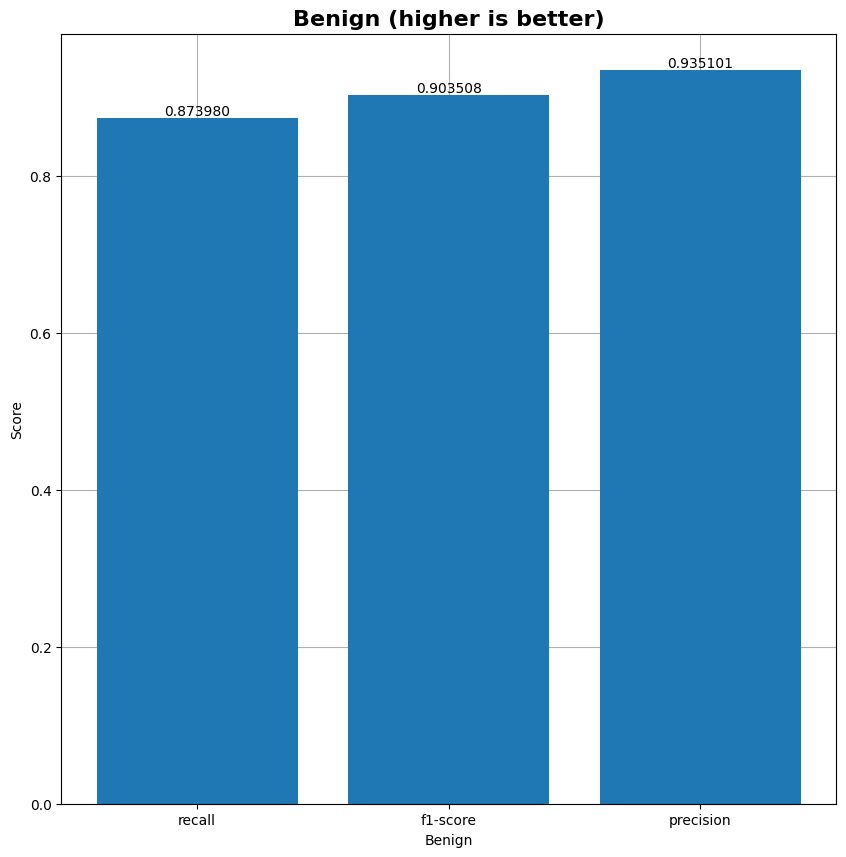

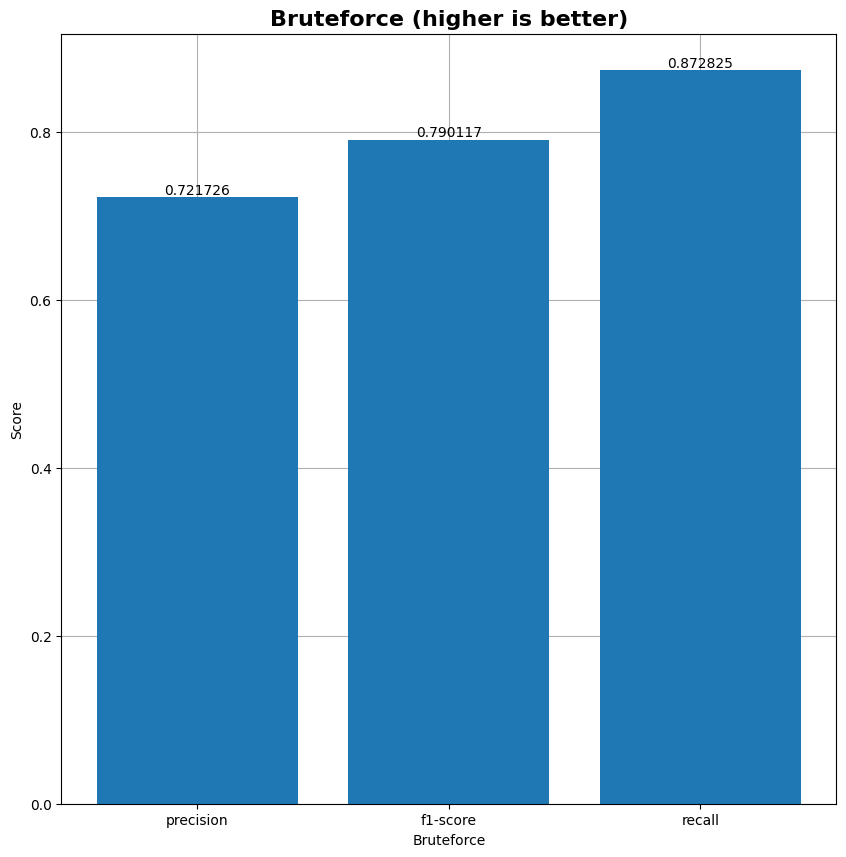

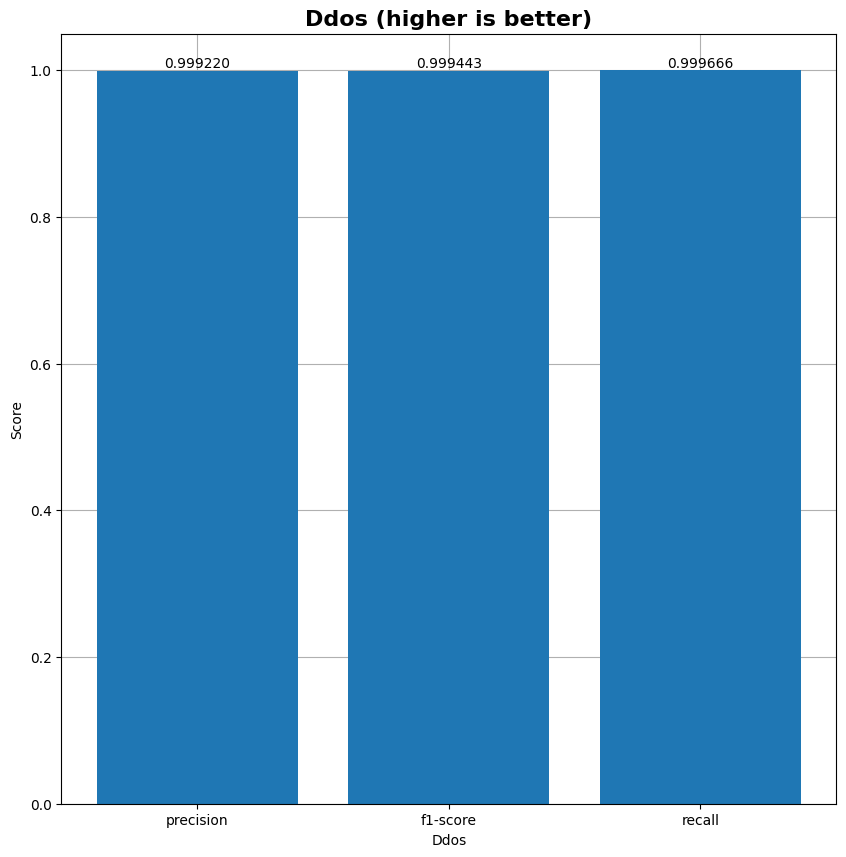

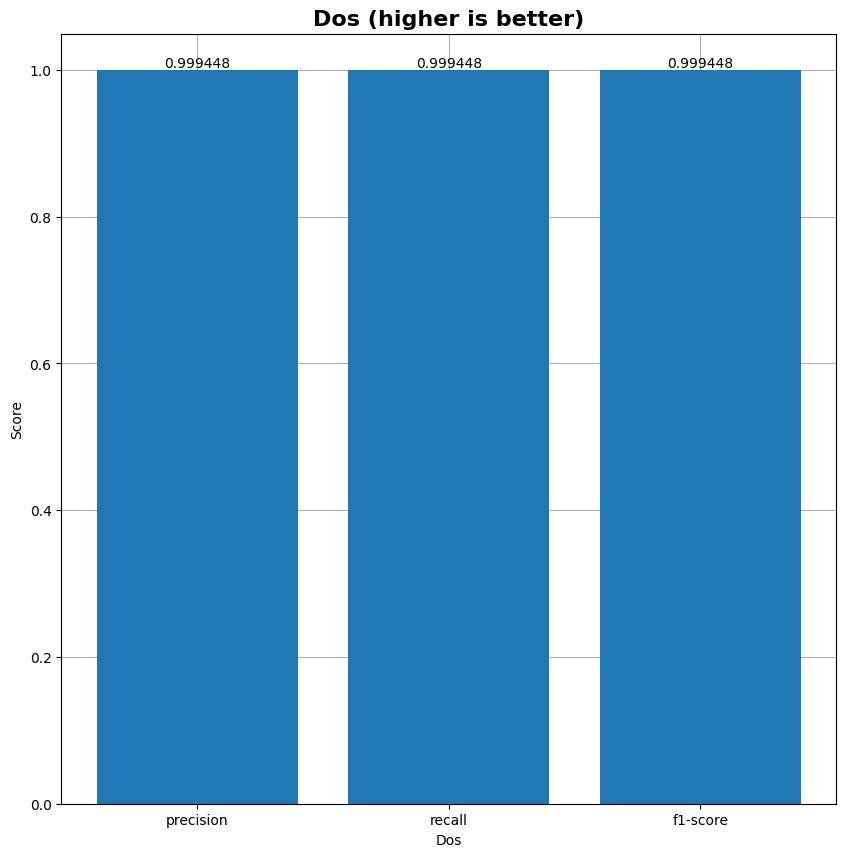

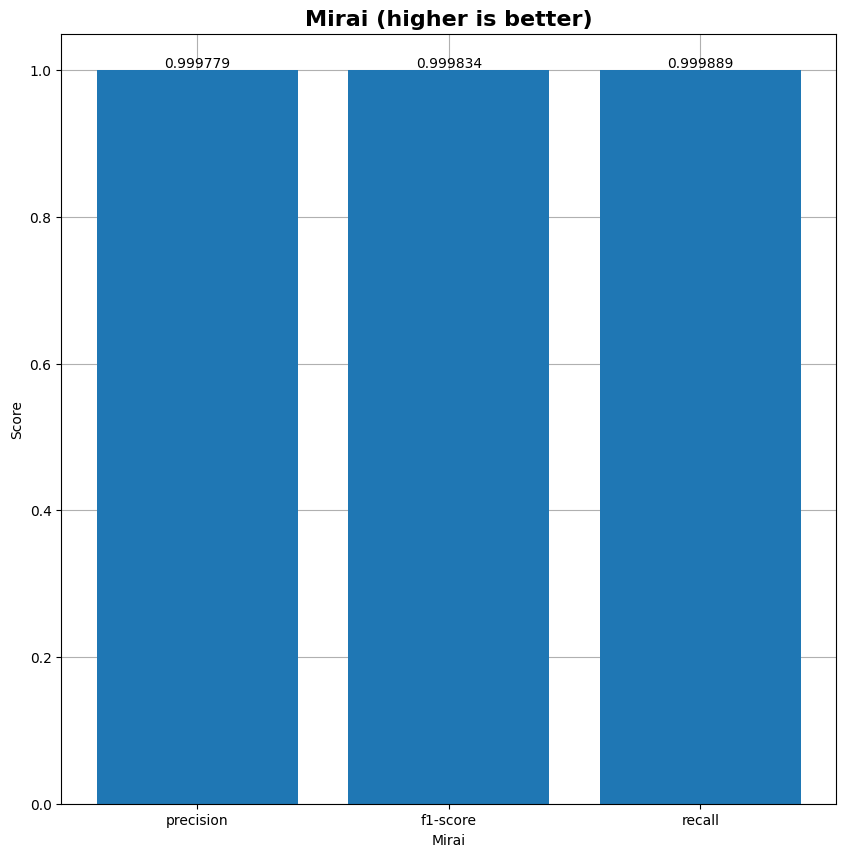

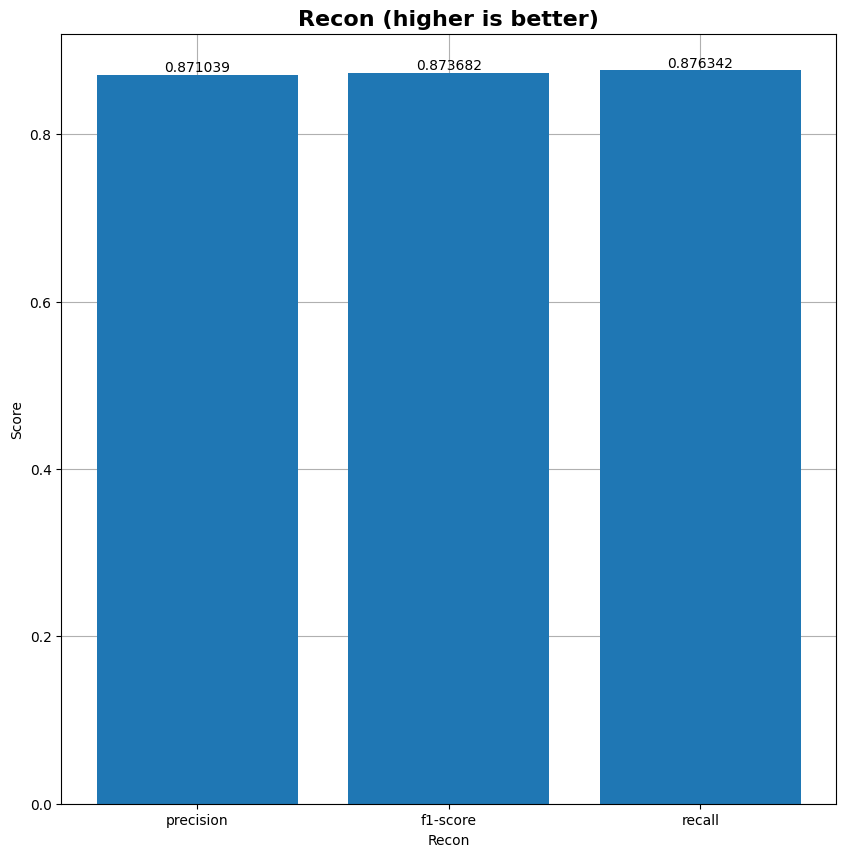

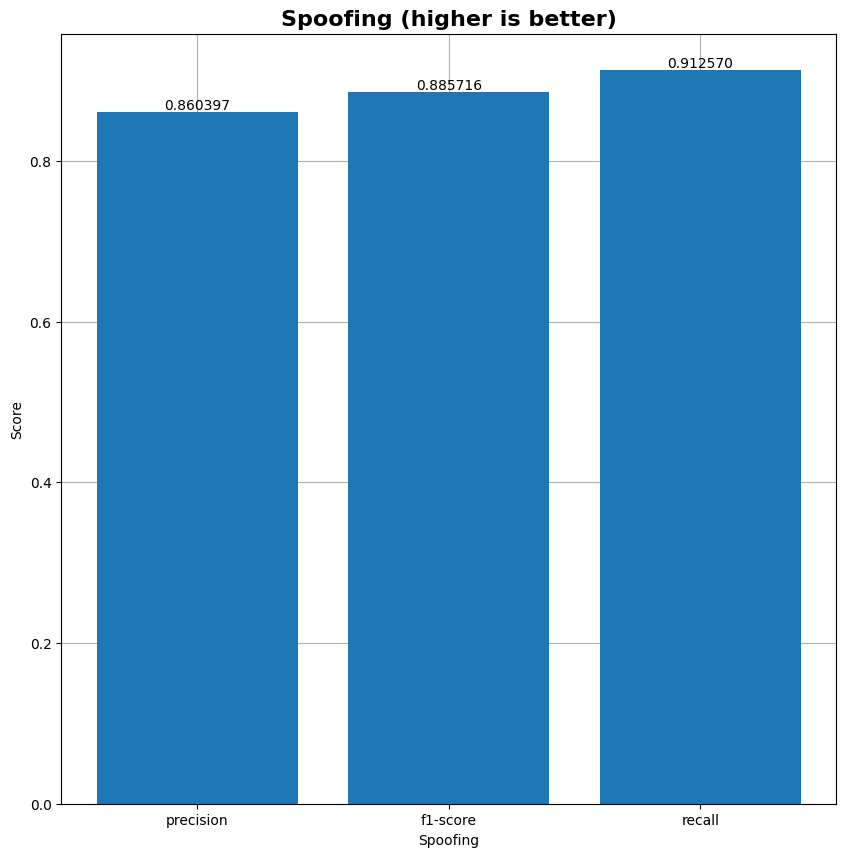

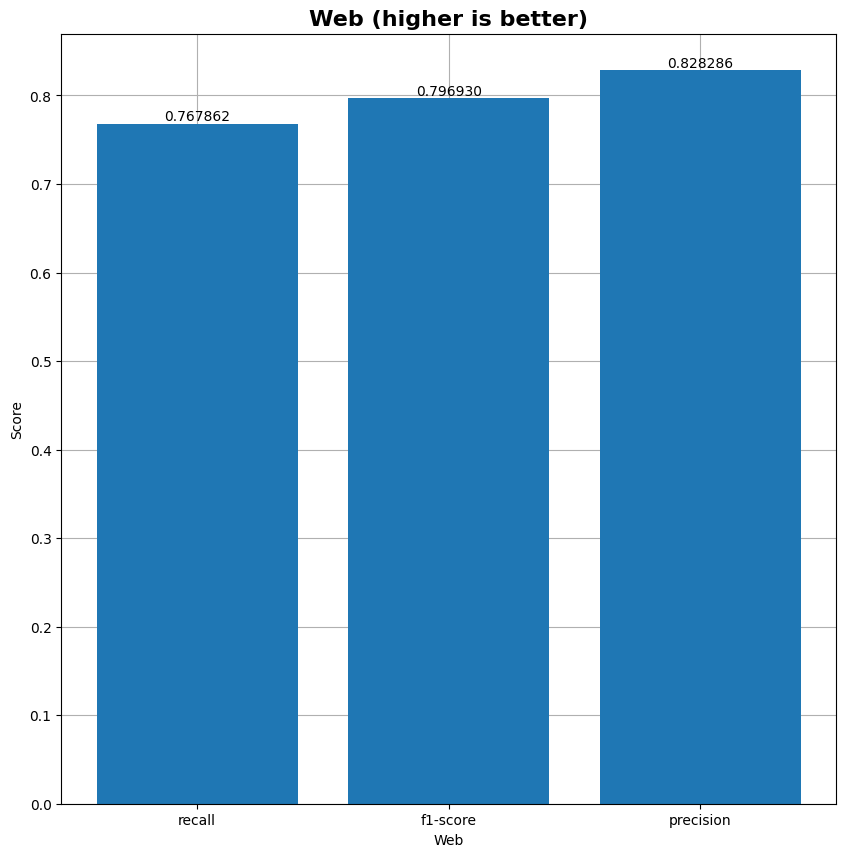

In [37]:
plot_mc(y_pred, y_test, "XGBoost")

In [38]:
model_name = "XGB_60000.sav"
pickle.dump(xgb_clf, open(model_name, 'wb'))

# LightGBM

In [39]:
%%time

start = time.time()

lgbm_clf = lightgbm.LGBMClassifier()
lgbm_clf.fit(X_train, y_train)
y_pred = lgbm_clf.predict(X_test)

end = time.time()

LightGBM_Time = end - start

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016801 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5360
[LightGBM] [Info] Number of data points in the train set: 338209, number of used features: 39
[LightGBM] [Info] Start training from score -1.890604
[LightGBM] [Info] Start training from score -3.421415
[LightGBM] [Info] Start training from score -1.891407
[LightGBM] [Info] Start training from score -1.893133
[LightGBM] [Info] Start training from score -1.892486
[LightGBM] [Info] Start training from score -1.893565
[LightGBM] [Info] Start training from score -1.889254
[LightGBM] [Info] Start training from score -2.772923


/home/kostas/Documents/git/Magistrinis/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


CPU times: user 38.6 s, sys: 150 ms, total: 38.8 s
Wall time: 9.85 s


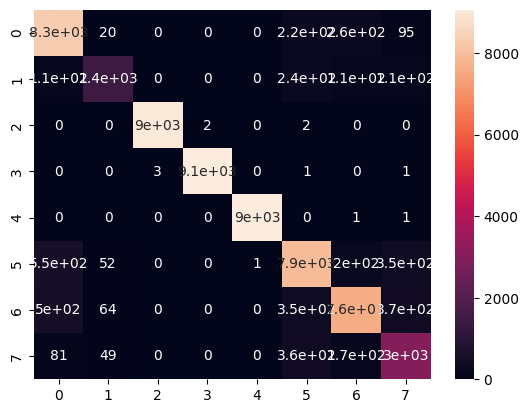

In [40]:
visualize_CM(confusion_matrix(y_test, y_pred))

In [41]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [42]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, LightGBM_Time]
results_dict["LightGBM"] = results

In [43]:
results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])

In [44]:
results_df

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Time
kNN,0.782320,0.782244,0.779781,0.782320,0.746857,0.792775,3.972287,1.993060,25.503519
RF,0.922827,0.923312,0.922340,0.922827,0.910142,0.263370,1.246046,1.116264,20.739691
XGBoost,0.929629,0.930481,0.929472,0.929629,0.918157,0.252011,1.218668,1.103933,12.092639
LightGBM,0.928373,0.929331,0.928187,0.928373,0.916694,0.256987,1.245526,1.116032,9.853697


             Benign  Bruteforce      DDoS       DoS     Mirai     Recon  \
precision  0.933423    0.715774  0.999554  0.999448  0.999779  0.873349   
recall     0.870046    0.886364  0.999666  0.999779  0.999889  0.870858   
f1-score   0.900621    0.791987  0.999610  0.999614  0.999834  0.872102   

           Spoofing       Web  
precision  0.855548  0.820443  
recall     0.911789  0.765968  
f1-score   0.882774  0.792271  


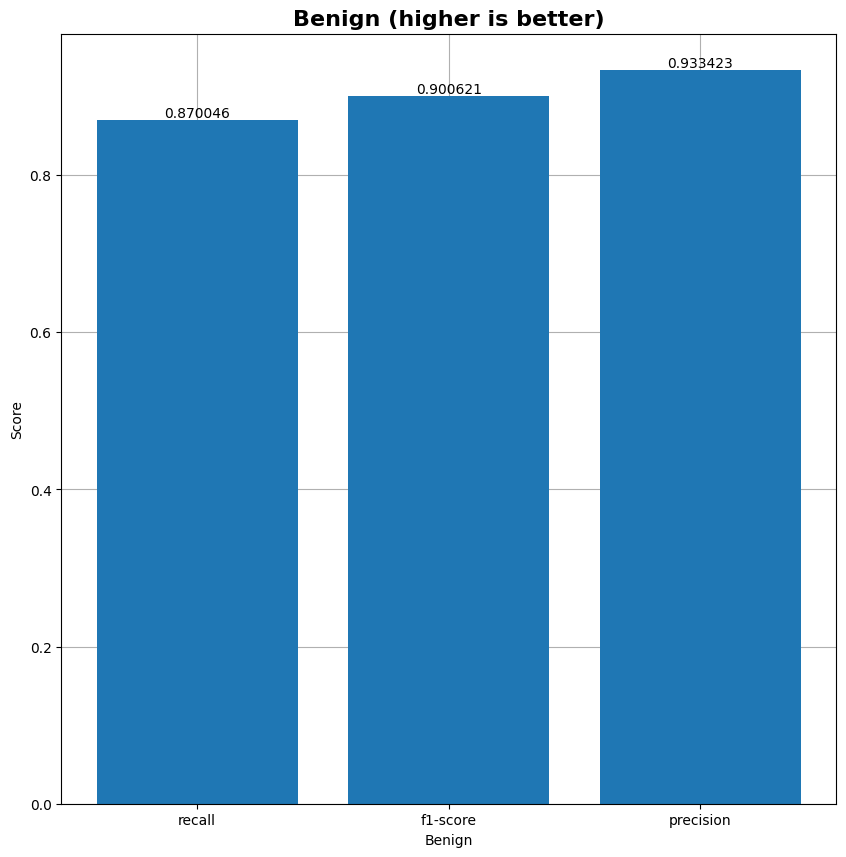

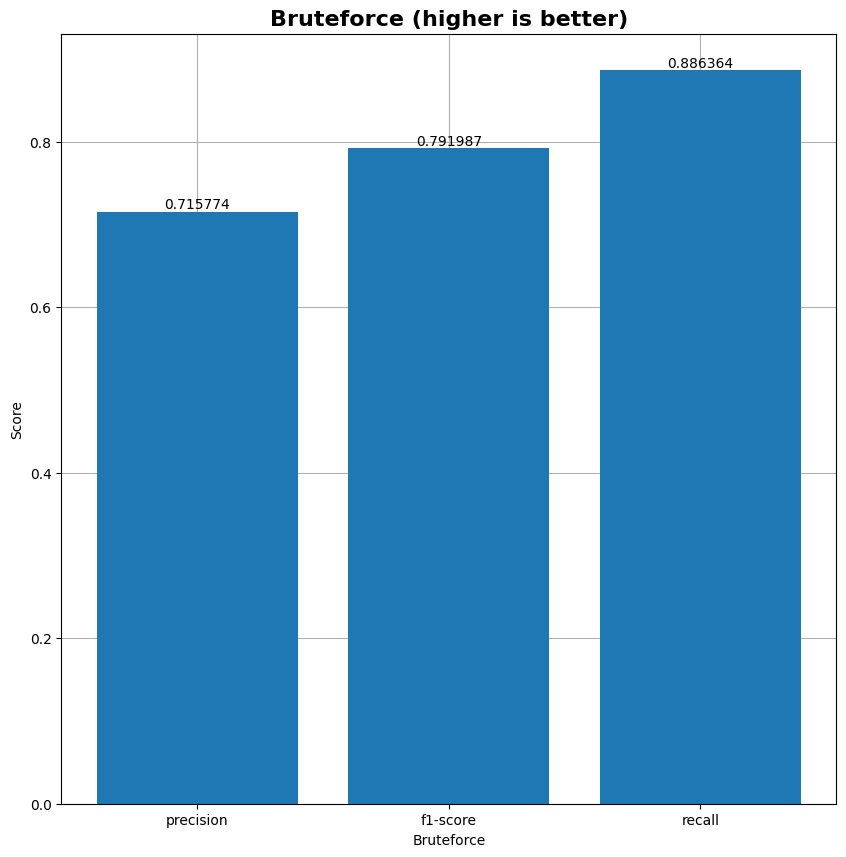

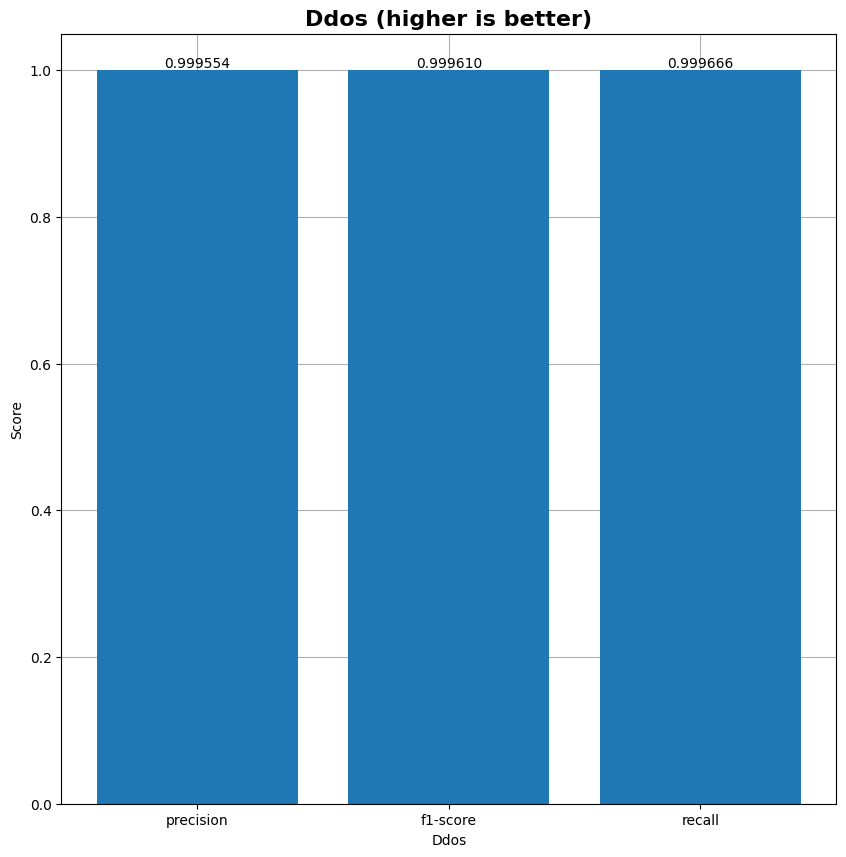

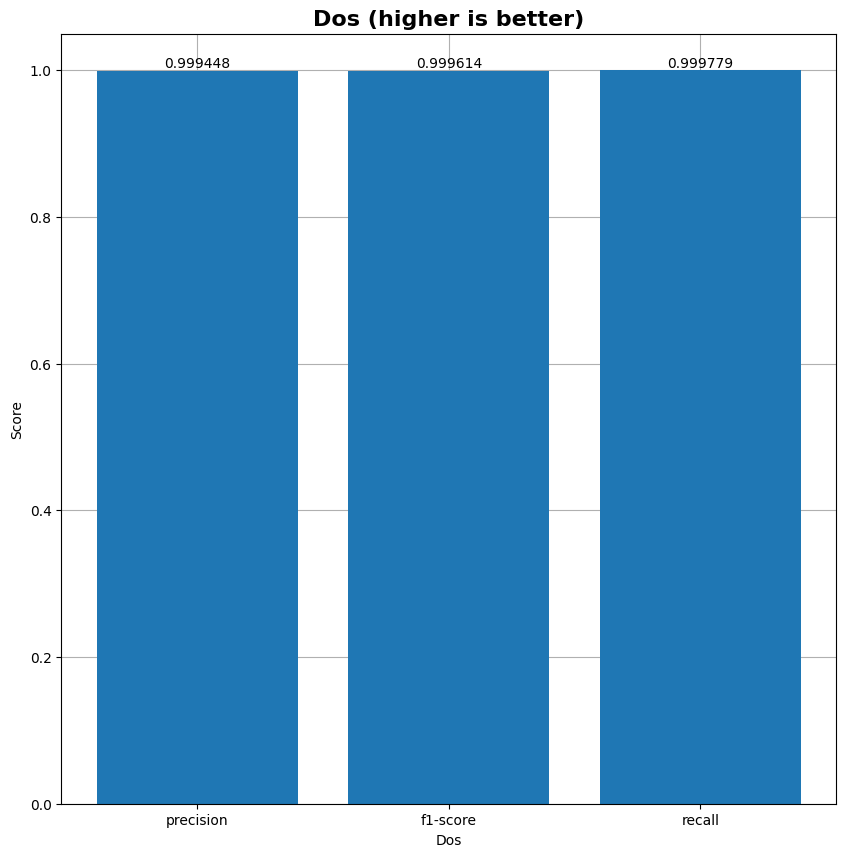

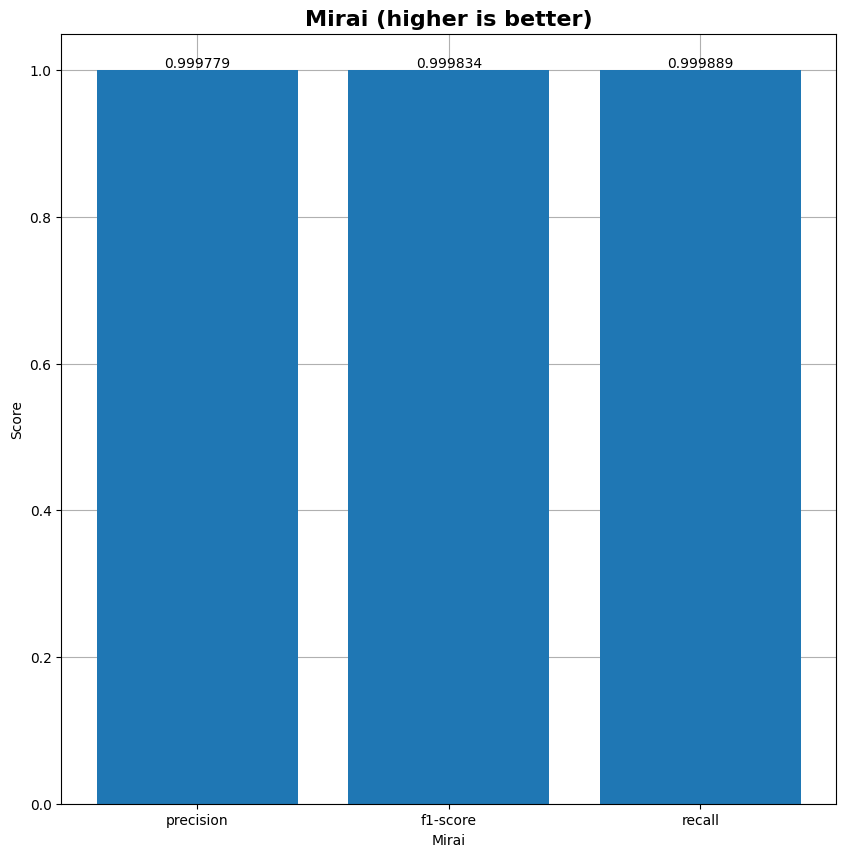

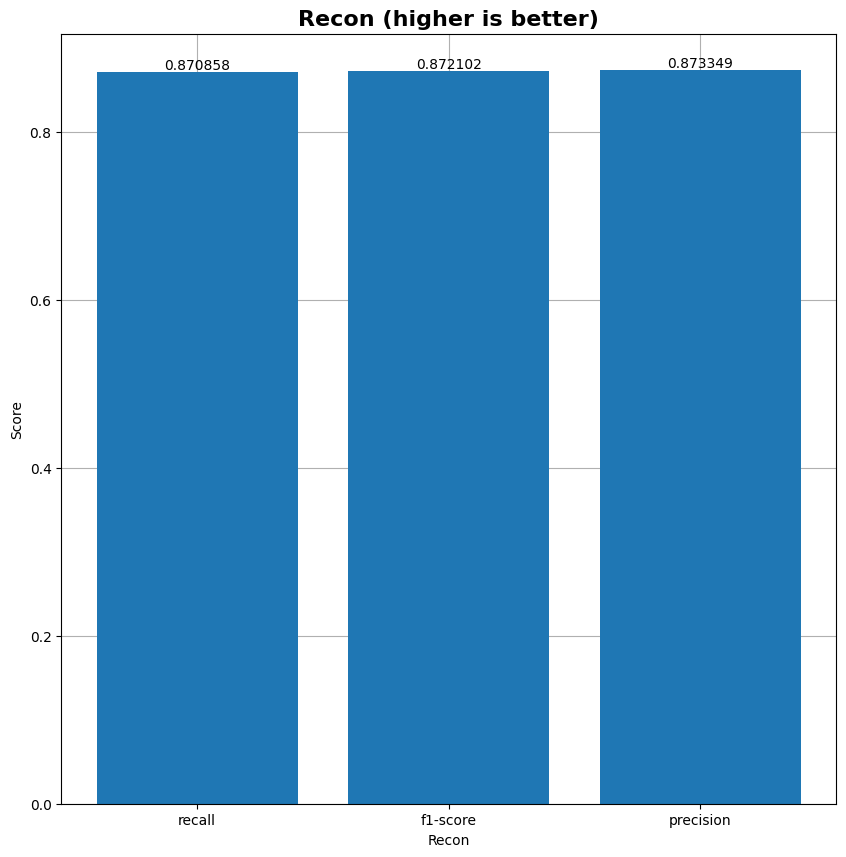

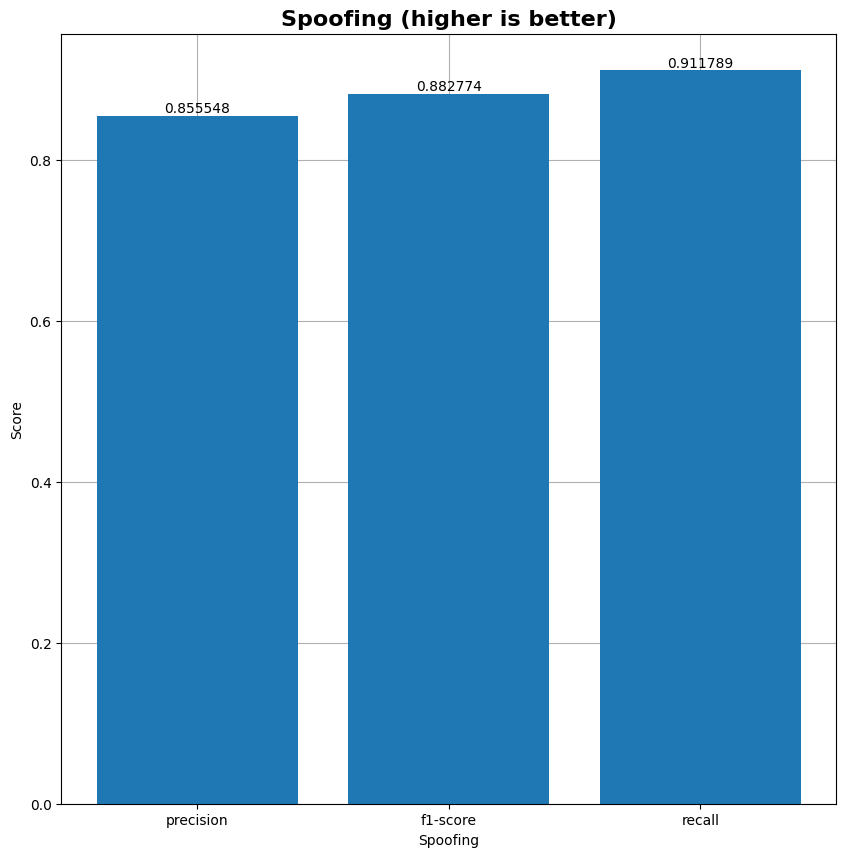

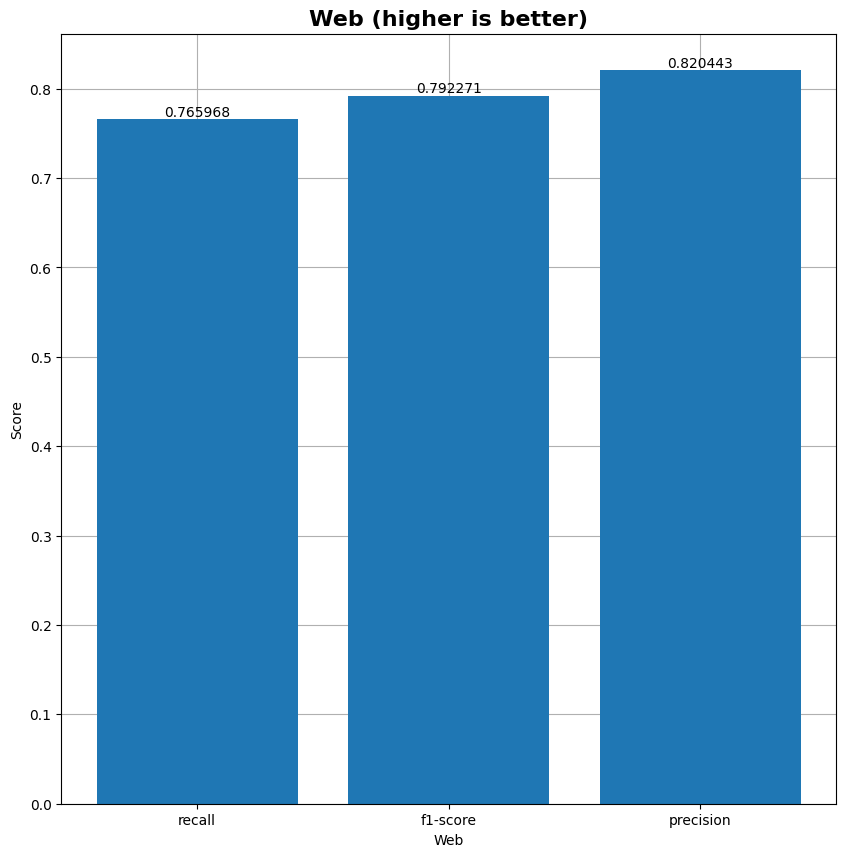

In [45]:
plot_mc(y_pred, y_test, "LightGBM")

In [46]:
model_name = "LightGBM_60000.sav"
pickle.dump(lgbm_clf, open(model_name, 'wb'))

# Feed Forward Neural Network

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.18)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((277331, 46), (277331,), (60878, 46), (60878,), (59684, 46), (59684,))

In [48]:
def create_model(X_train, y_train):
    model = keras.Sequential()
    model.add(keras.layers.Dense(X_train.shape[1], activation='relu', input_shape=(X_train.shape[1],)))
    model.add(keras.layers.Dense(1024, activation='relu'))
    model.add(keras.layers.Dense(512, activation='relu'))
    model.add(keras.layers.Dense(len(np.unique(y_train)), activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model
model = create_model(X_train, y_train)

/home/kostas/Documents/git/Magistrinis/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1744567296.480296  212282 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5295 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1


In [49]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 46)             │         2,162 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │        48,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         4,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 579,194 (2.21 MB)

 Trainable params: 579,194 (2.21 MB)

 Non-trainable params: 0 (0.00 B)

In [50]:
%%time

start = time.time()

model.fit(X_train, y_train,
          batch_size=16,
          epochs=20,
          validation_data=(X_val, y_val))
gc.collect();

y_pred = model.predict(X_test)

end = time.time()

FFNN_Time = end - start

Epoch 1/20


I0000 00:00:1744567298.030978  213743 service.cc:152] XLA service 0x789c70005e80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744567298.030993  213743 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1060, Compute Capability 6.1
2025-04-13 21:01:38.053338: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744567298.191854  213743 cuda_dnn.cc:529] Loaded cuDNN version 90300


   81/17334 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step - accuracy: 0.4989 - loss: 1.3497   

I0000 00:00:1744567299.012660  213743 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


17334/17334 ━━━━━━━━━━━━━━━━━━━━ 39s 2ms/step - accuracy: 0.7069 - loss: 0.6864 - val_accuracy: 0.7530 - val_loss: 0.5832
Epoch 2/20
17334/17334 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step - accuracy: 0.7565 - loss: 0.5646 - val_accuracy: 0.7618 - val_loss: 0.5410
Epoch 3/20
17334/17334 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step - accuracy: 0.7663 - loss: 0.5412 - val_accuracy: 0.7731 - val_loss: 0.5349
Epoch 4/20
17334/17334 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step - accuracy: 0.7733 - loss: 0.5290 - val_accuracy: 0.7700 - val_loss: 0.5314
Epoch 5/20
17334/17334 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step - accuracy: 0.7757 - loss: 0.5227 - val_accuracy: 0.7636 - val_loss: 0.5542
Epoch 6/20
17334/17334 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step - accuracy: 0.7782 - loss: 0.5166 - val_accuracy: 0.7744 - val_loss: 0.5281
Epoch 7/20
17334/17334 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step - accuracy: 0.7789 - loss: 0.5135 - val_accuracy: 0.7747 - val_loss: 0.5263
Epoch 8/20
17334/17334 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step - accuracy: 0.7782 - lo

In [51]:
y_pred = np.argmax(y_pred, axis=1)

In [52]:
_, accuracy = model.evaluate(X_test, y_test)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

1866/1866 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7857 - loss: 0.7455


In [53]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, FFNN_Time]
results_dict["FF-NN"] = results

In [54]:
results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])

In [55]:
results_df

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Time
kNN,0.782320,0.782244,0.779781,0.782320,0.746857,0.792775,3.972287,1.993060,25.503519
RF,0.922827,0.923312,0.922340,0.922827,0.910142,0.263370,1.246046,1.116264,20.739691
XGBoost,0.929629,0.930481,0.929472,0.929629,0.918157,0.252011,1.218668,1.103933,12.092639
LightGBM,0.928373,0.929331,0.928187,0.928373,0.916694,0.256987,1.245526,1.116032,9.853697
FF-NN,0.785135,0.787205,0.784719,0.785135,0.749866,0.612141,2.711430,1.646642,751.819907


             Benign  Bruteforce      DDoS       DoS     Mirai     Recon  \
precision  0.809899    0.415211  0.798392  0.795601  0.993992  0.763353   
recall     0.783468    0.596750  0.804686  0.794704  0.997878  0.681845   
f1-score   0.796464    0.489697  0.801526  0.795152  0.995931  0.720301   

           Spoofing       Web  
precision  0.709489  0.591826  
recall     0.804519  0.536826  
f1-score   0.754022  0.562986  


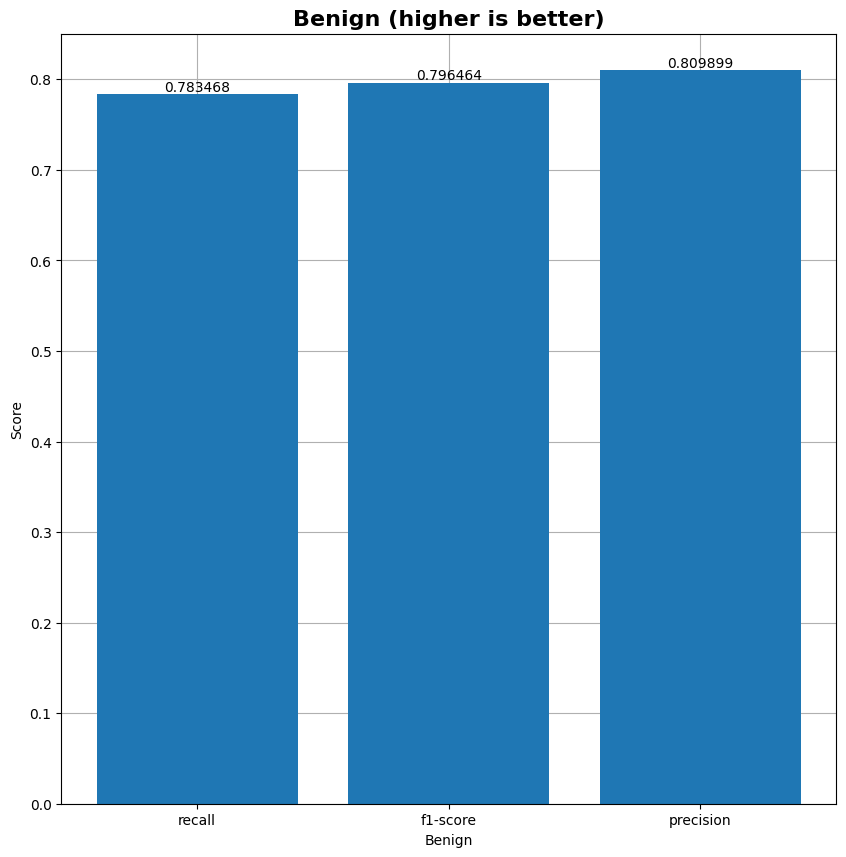

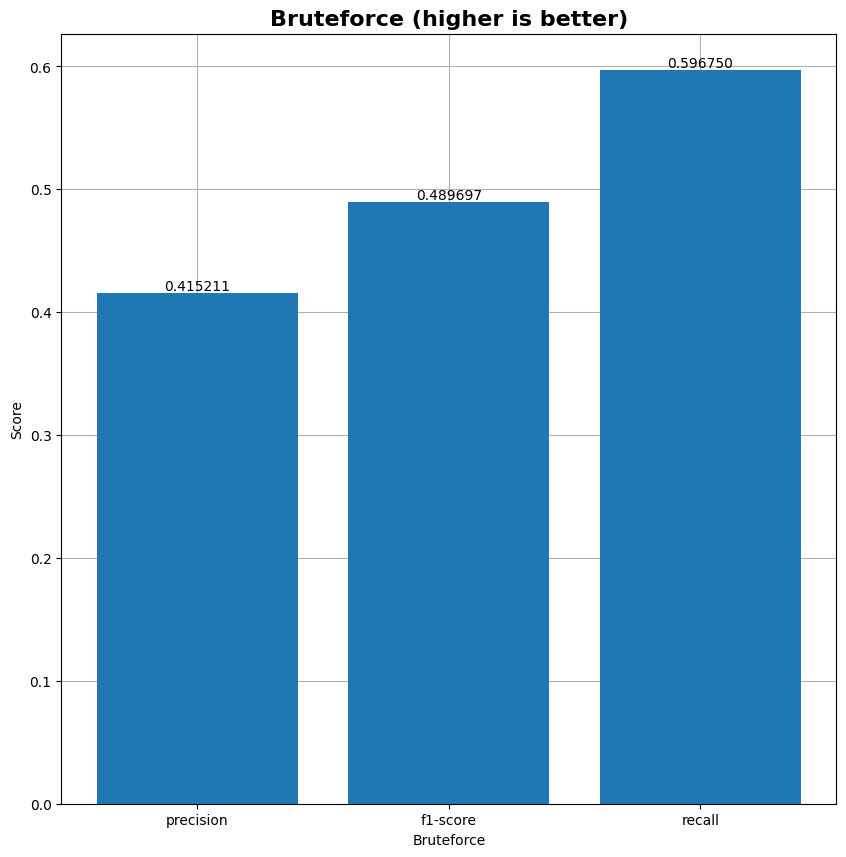

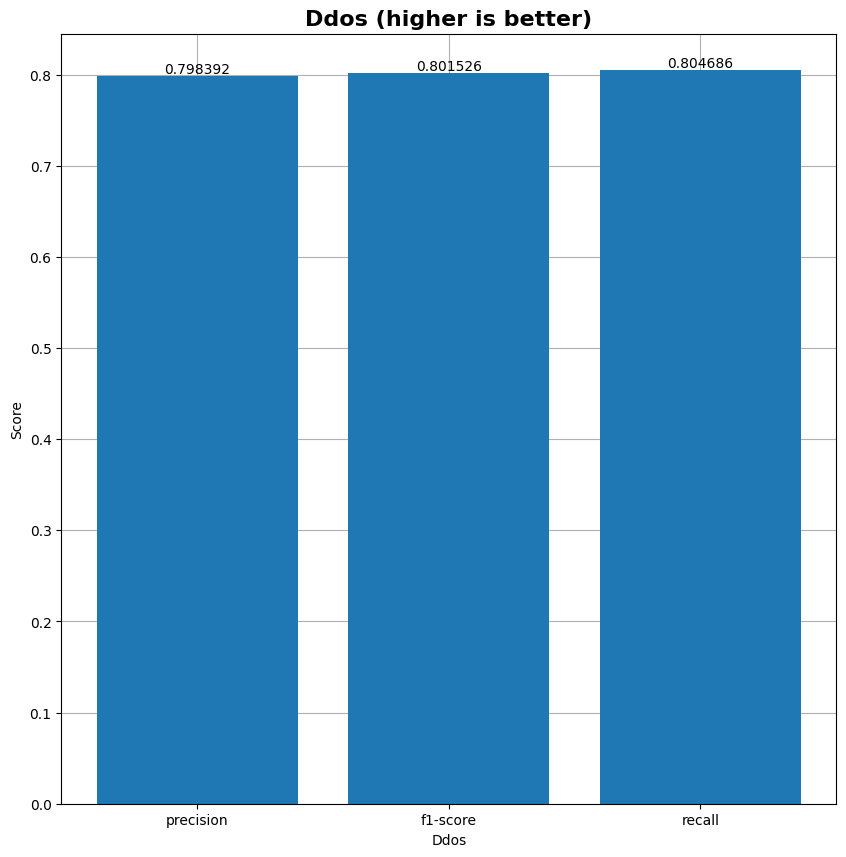

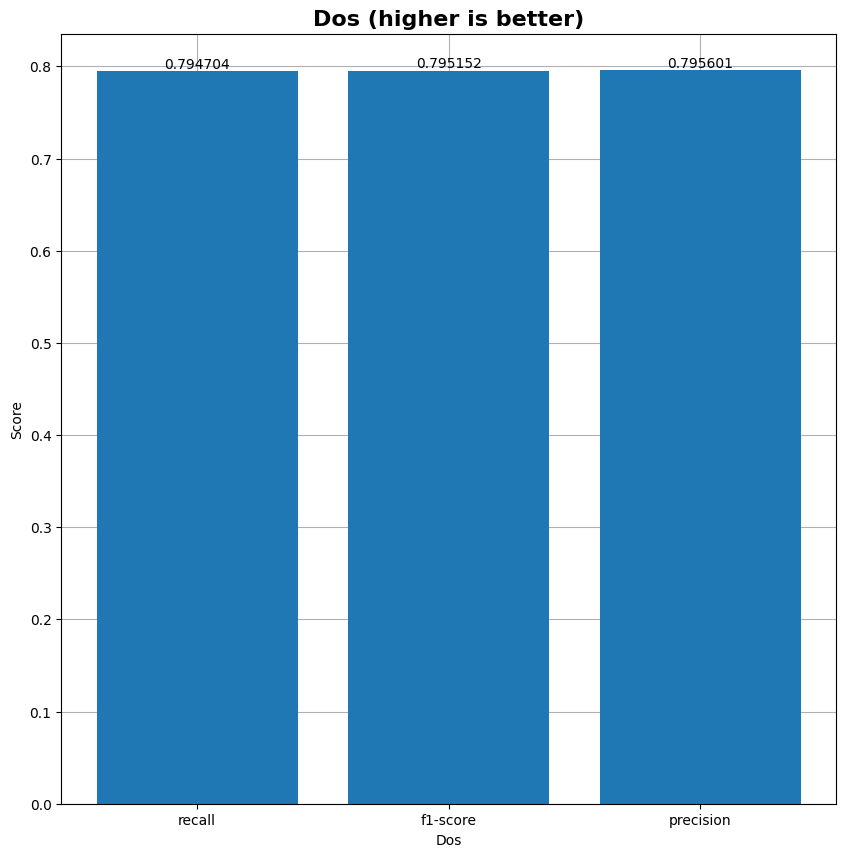

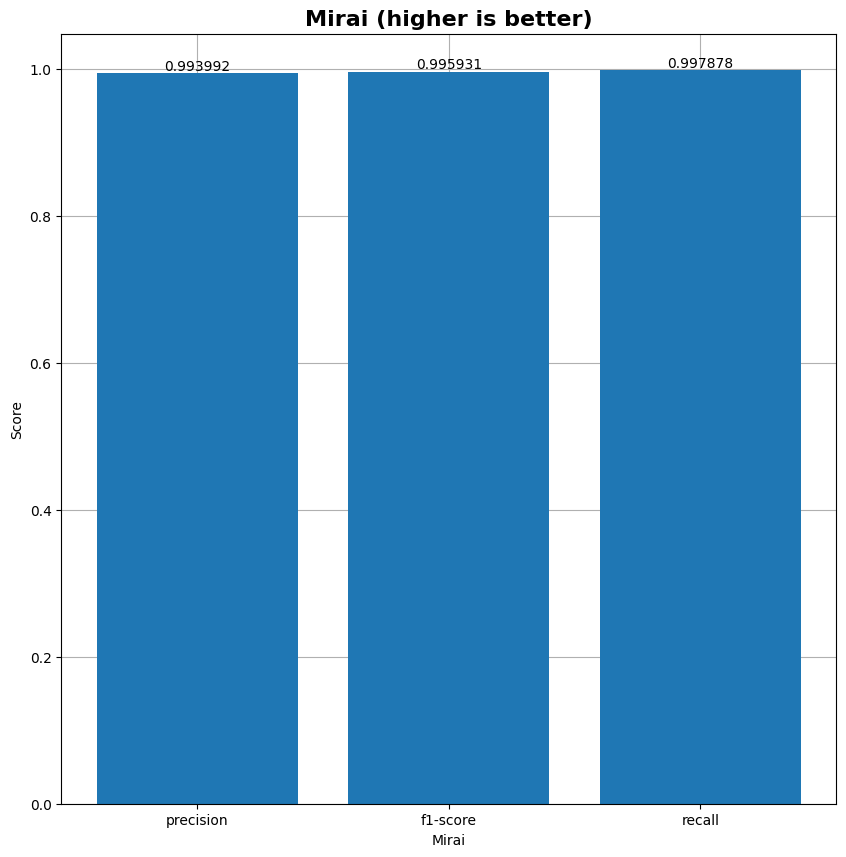

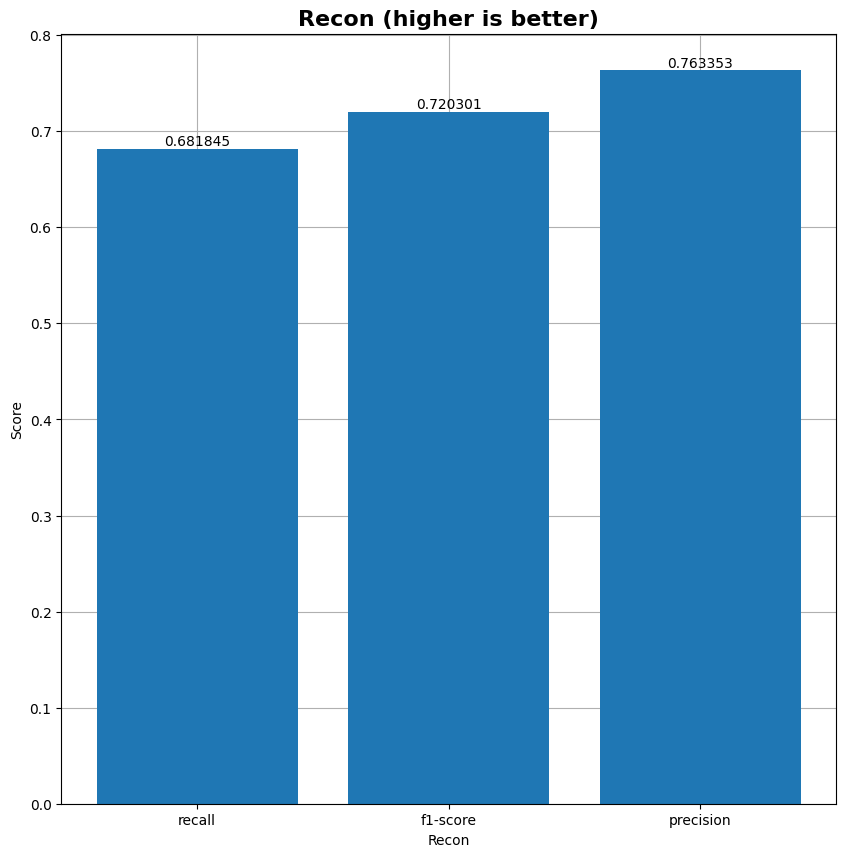

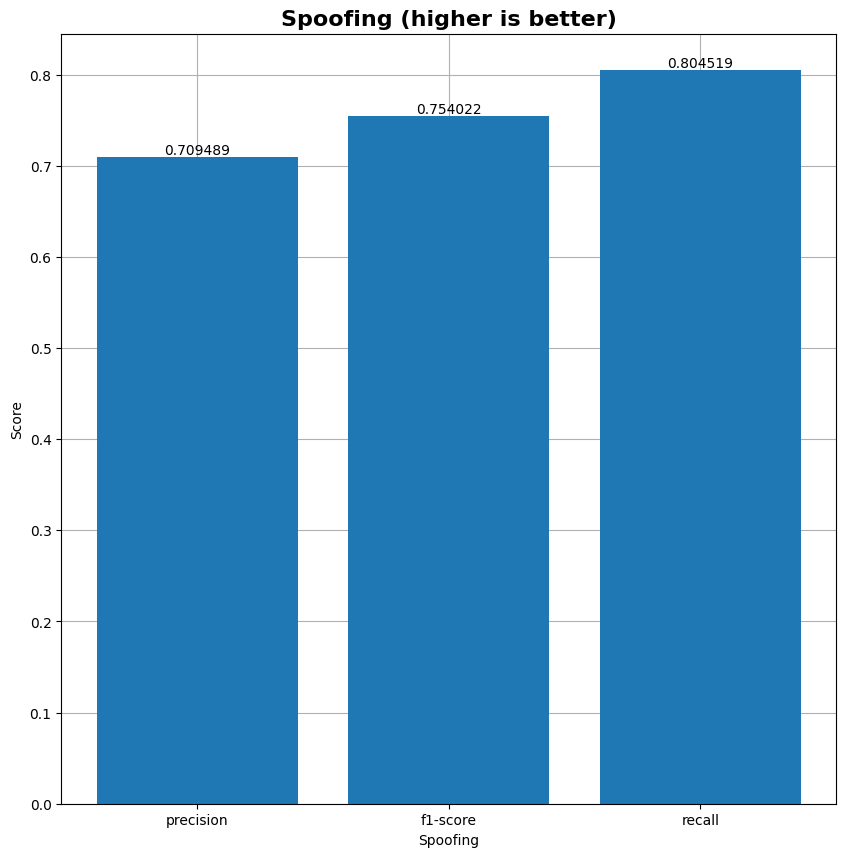

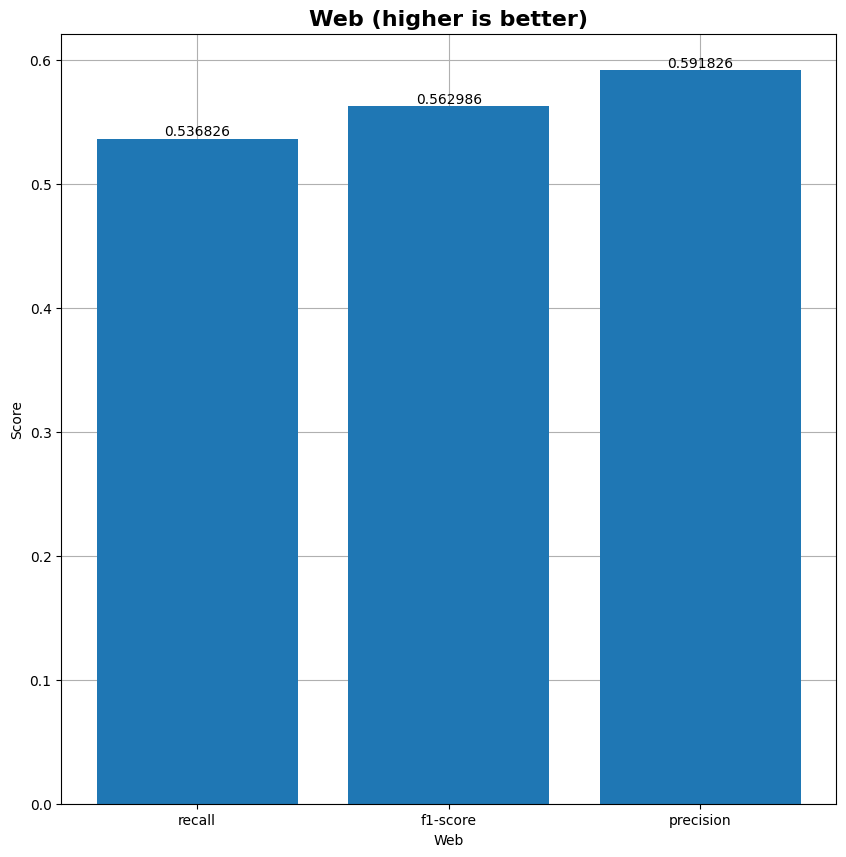

In [56]:
plot_mc(y_pred, y_test, "FF-NN")

In [57]:
model_name = "FFNN_60000.sav"
pickle.dump(model, open(model_name, 'wb'))

# LSTM

In [58]:
# Prepare sequential data
def create_sequences(features, labels, seq_length):
    sequences, seq_labels = [], []
    for i in range(len(features) - seq_length):
        sequences.append(features[i:i + seq_length])
        seq_labels.append(labels[i + seq_length - 1])  # Use the last label in the sequence
    return np.array(sequences), np.array(seq_labels)

In [59]:
num_components = len(np.unique(y))

In [60]:
# Create sequences
seq_length = 20
X1, y1 = create_sequences(X, y, seq_length)
y1 = to_categorical(y1, num_classes=num_components)  # Convert labels to one-hot encoding

In [61]:
# Split data
X_train, X_temp, y_train, y_temp = train_test_split(X1, y1, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [62]:
def create_model_LSTM(input_shape, num_classes):
    model = keras.Sequential([
        keras.layers.LSTM(64, input_shape=input_shape, return_sequences=True),
        keras.layers.Dropout(0.3),
        keras.layers.LSTM(32),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(num_classes, activation='softmax')  # Use softmax for multi-class classification
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [63]:
# Build model
model = create_model_LSTM(input_shape=(seq_length, X1.shape[2]), num_classes=num_components)

/home/kostas/Documents/git/Magistrinis/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [64]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20, 64)         │        28,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,464 (169.78 KB)

 Trainable params: 43,464 (169.78 KB)

 Non-trainable params: 0 (0.00 B)

In [65]:
%%time

start = time.time()

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val)
)

# Evaluate model
y_pred = model.predict(X_test)

end = time.time()

LSTM_Time = end - start

Epoch 1/10
8704/8704 ━━━━━━━━━━━━━━━━━━━━ 60s 7ms/step - accuracy: 0.9797 - loss: 0.0812 - val_accuracy: 0.9994 - val_loss: 0.0028
Epoch 2/10
8704/8704 ━━━━━━━━━━━━━━━━━━━━ 57s 7ms/step - accuracy: 0.9992 - loss: 0.0035 - val_accuracy: 0.9997 - val_loss: 0.0022
Epoch 3/10
8704/8704 ━━━━━━━━━━━━━━━━━━━━ 57s 7ms/step - accuracy: 0.9997 - loss: 0.0015 - val_accuracy: 0.9972 - val_loss: 0.0146
Epoch 4/10
8704/8704 ━━━━━━━━━━━━━━━━━━━━ 57s 7ms/step - accuracy: 0.9997 - loss: 0.0013 - val_accuracy: 0.9998 - val_loss: 0.0011
Epoch 5/10
8704/8704 ━━━━━━━━━━━━━━━━━━━━ 57s 7ms/step - accuracy: 0.9998 - loss: 9.6406e-04 - val_accuracy: 0.9999 - val_loss: 4.7463e-04
Epoch 6/10
8704/8704 ━━━━━━━━━━━━━━━━━━━━ 57s 7ms/step - accuracy: 0.9997 - loss: 0.0014 - val_accuracy: 0.9998 - val_loss: 7.0257e-04
Epoch 7/10
8704/8704 ━━━━━━━━━━━━━━━━━━━━ 57s 7ms/step - accuracy: 0.9998 - loss: 7.5550e-04 - val_accuracy: 0.9999 - val_loss: 6.1709e-04
Epoch 8/10
8704/8704 ━━━━━━━━━━━━━━━━━━━━ 57s 7ms/step - accura

In [66]:
_, accuracy = model.evaluate(X_test, y_test)

1866/1866 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9999 - loss: 0.0020    


In [67]:
y_test = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)

In [68]:
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mcc = matthews_corrcoef(y_true=y_test,y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

In [69]:
results = [accuracy, precision, f1, recall, mcc, mae, mse, rmse, LSTM_Time]
results_dict["LSTM"] = results

In [70]:
results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])

In [71]:
results_df

,Accuracy,Precision,F1,Recall,MCC,MAE,MSE,RMSE,Time
kNN,0.782320,0.782244,0.779781,0.782320,0.746857,0.792775,3.972287,1.993060,25.503519
RF,0.922827,0.923312,0.922340,0.922827,0.910142,0.263370,1.246046,1.116264,20.739691
XGBoost,0.929629,0.930481,0.929472,0.929629,0.918157,0.252011,1.218668,1.103933,12.092639
LightGBM,0.928373,0.929331,0.928187,0.928373,0.916694,0.256987,1.245526,1.116032,9.853697
FF-NN,0.785135,0.787205,0.784719,0.785135,0.749866,0.612141,2.711430,1.646642,751.819907
LSTM,0.999832,0.999833,0.999832,0.999832,0.999805,0.000637,0.002714,0.052100,579.178282


             Benign  Bruteforce  DDoS  DoS  Mirai     Recon  Spoofing  \
precision  1.000000    0.999496   1.0  1.0    1.0  0.998992  1.000000   
recall     0.999890    0.996985   1.0  1.0    1.0  1.000000  0.999888   
f1-score   0.999945    0.998239   1.0  1.0    1.0  0.999496  0.999944   

                Web  
precision  1.000000  
recall     0.999481  
f1-score   0.999740  


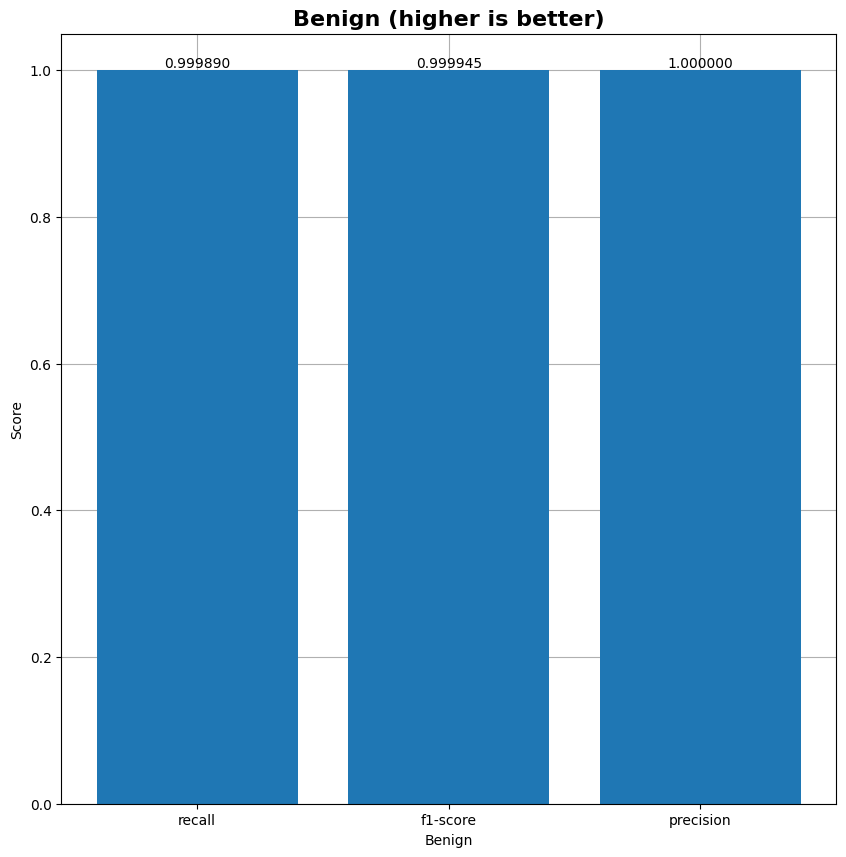

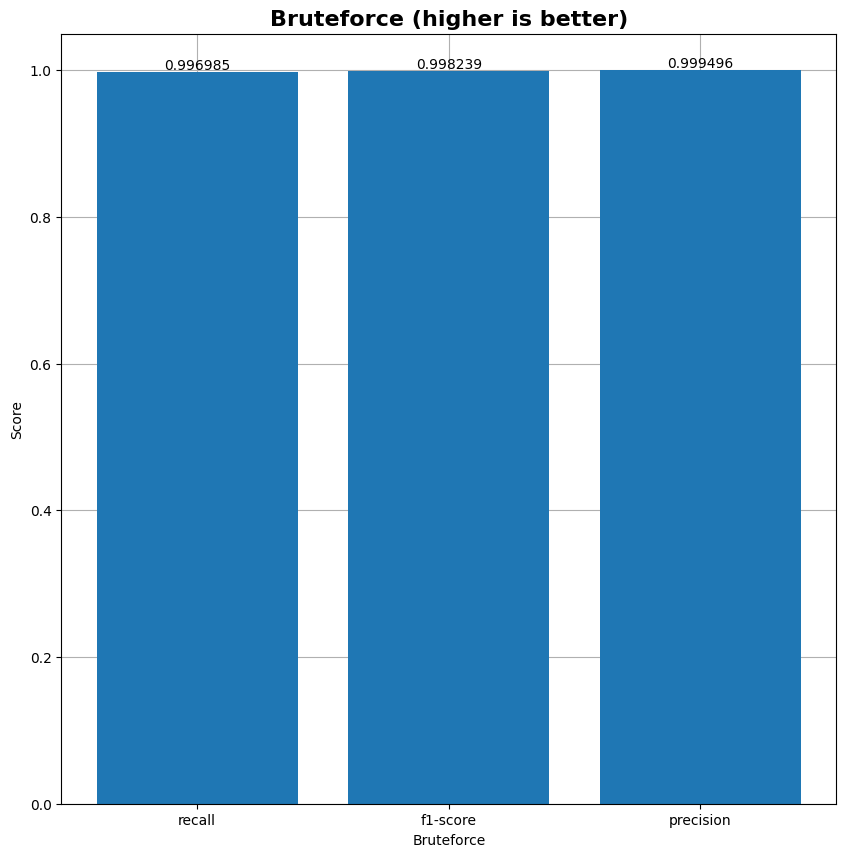

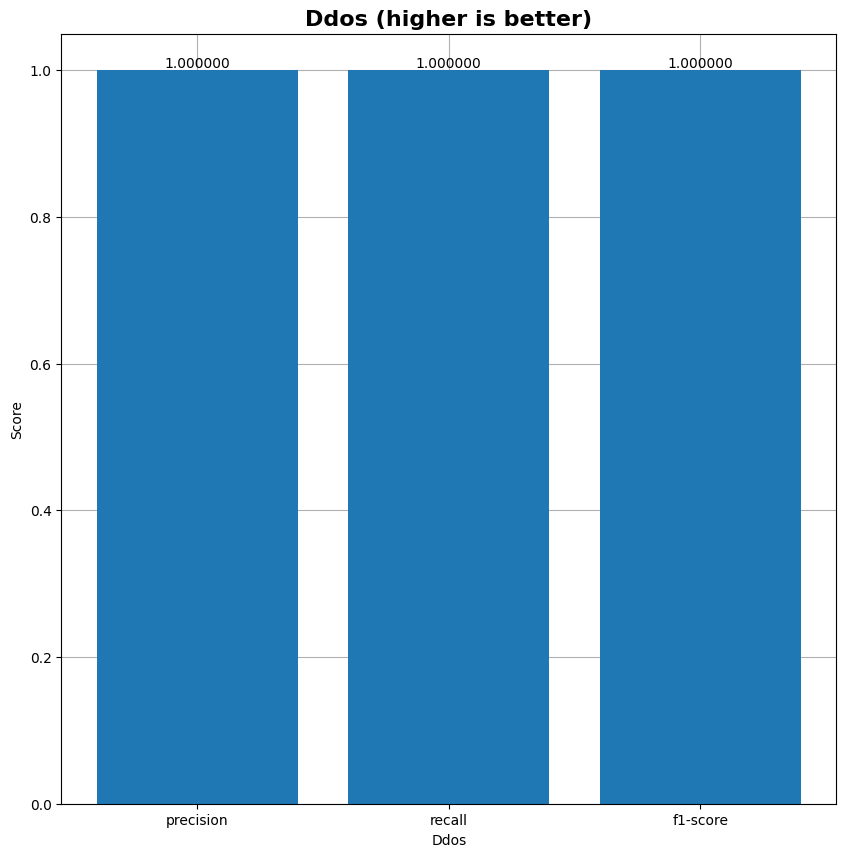

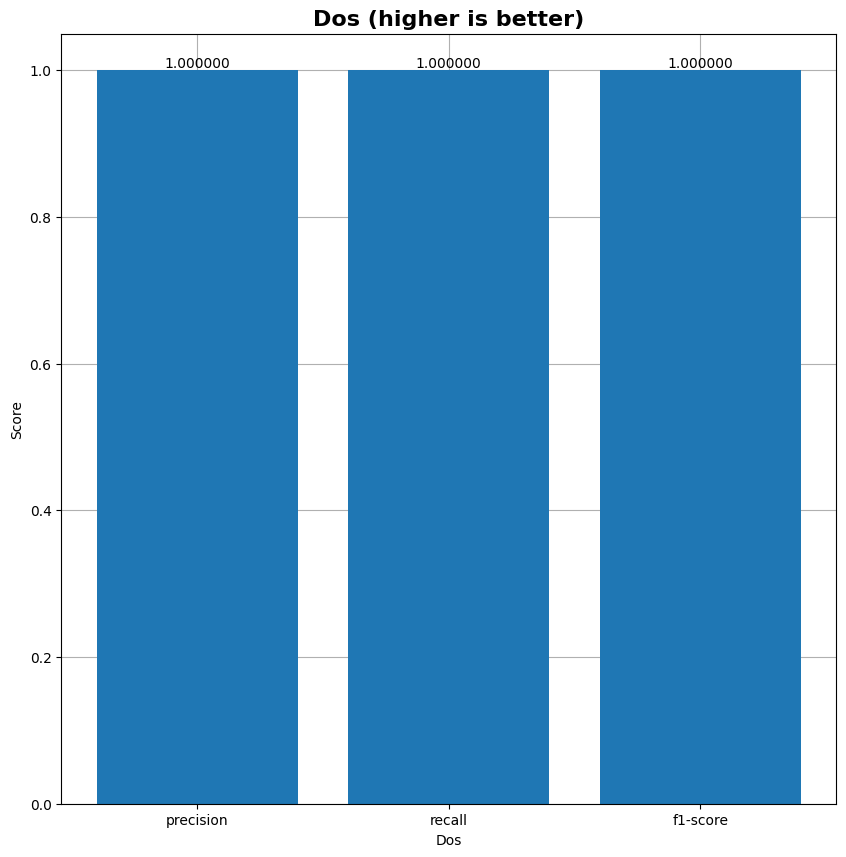

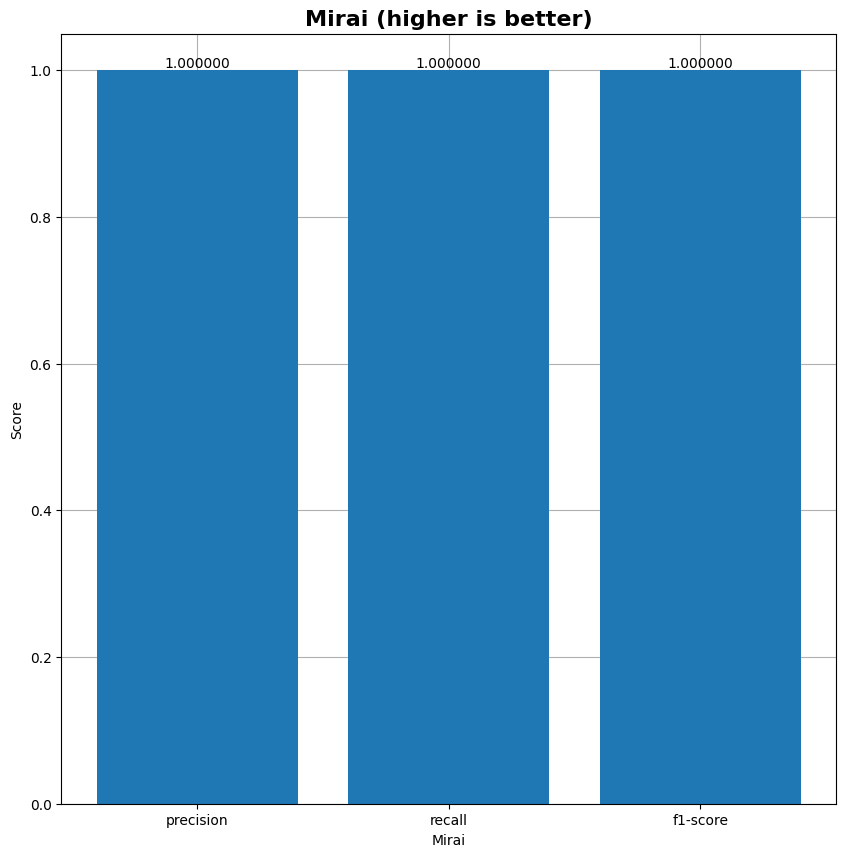

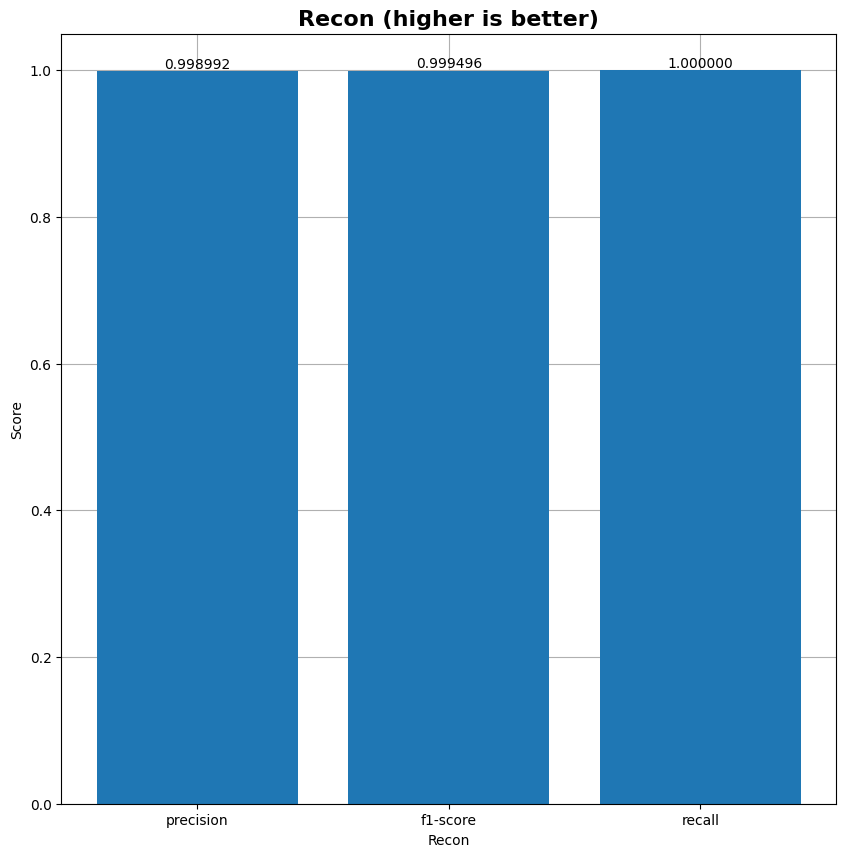

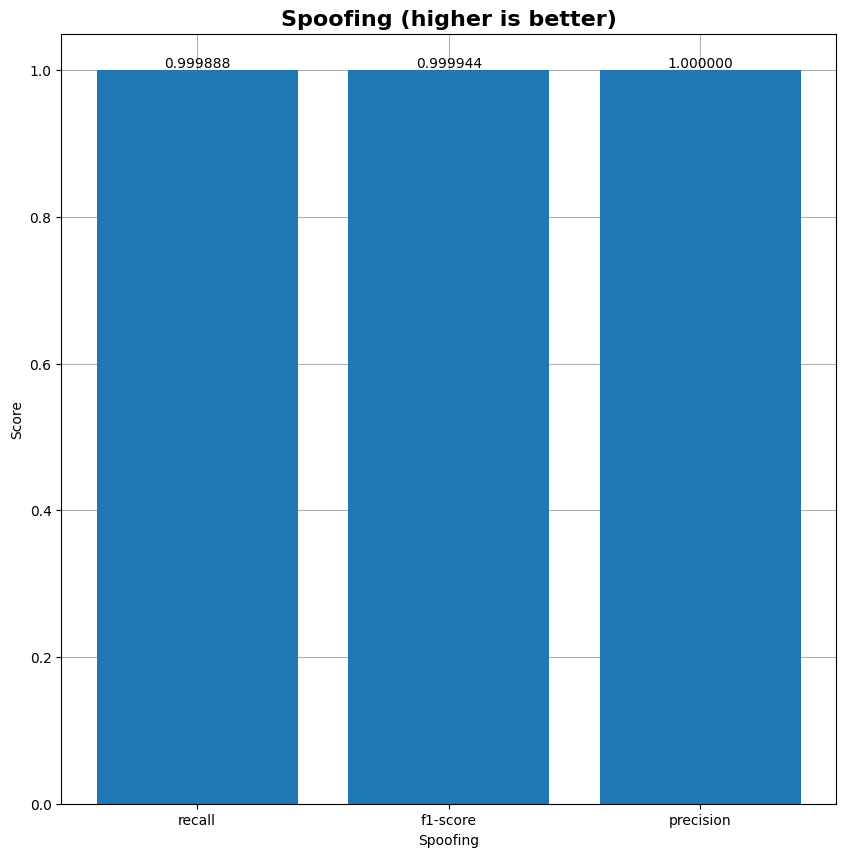

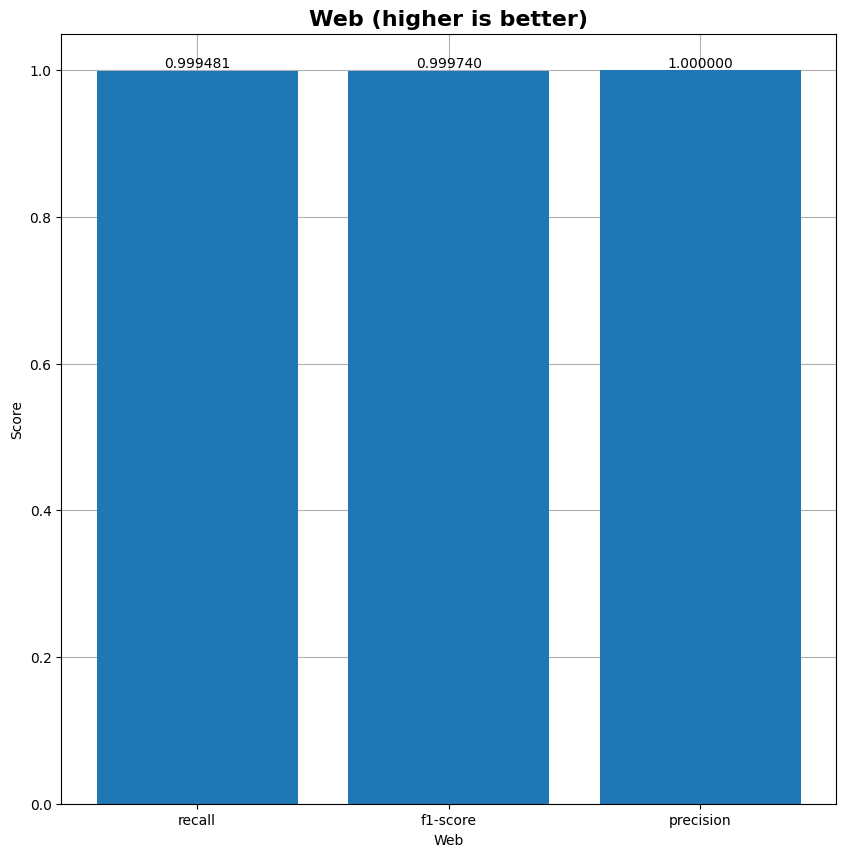

In [72]:
plot_mc(y_pred, y_test, "LSTM")

In [73]:
model_name = "LSTM_60000.sav"
pickle.dump(model, open(model_name, 'wb'))

# Plot data

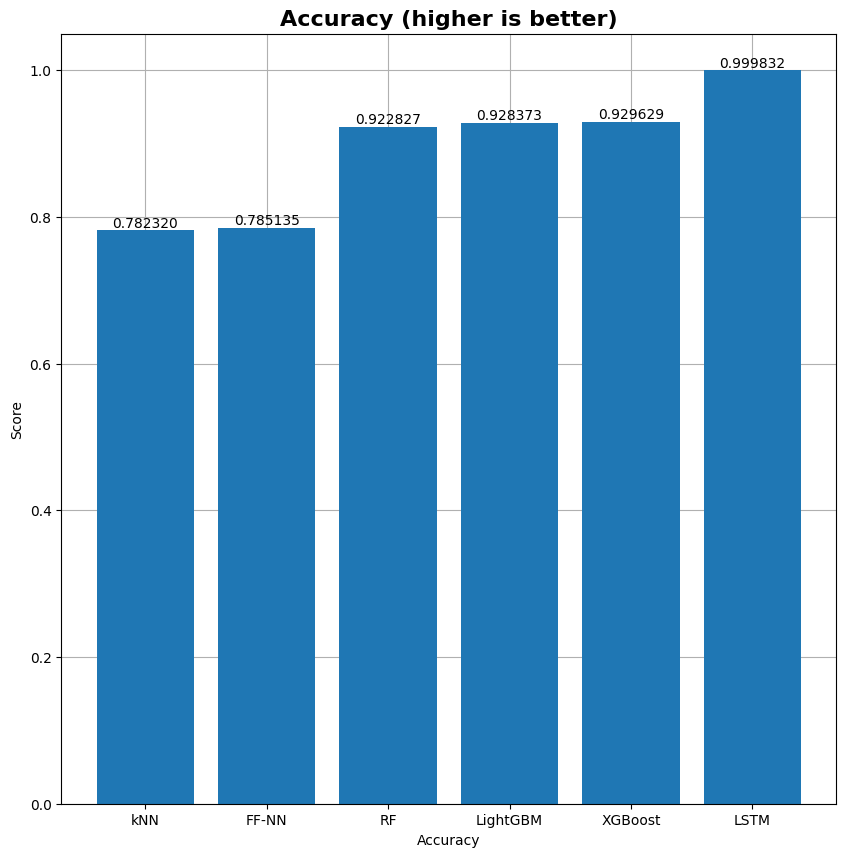

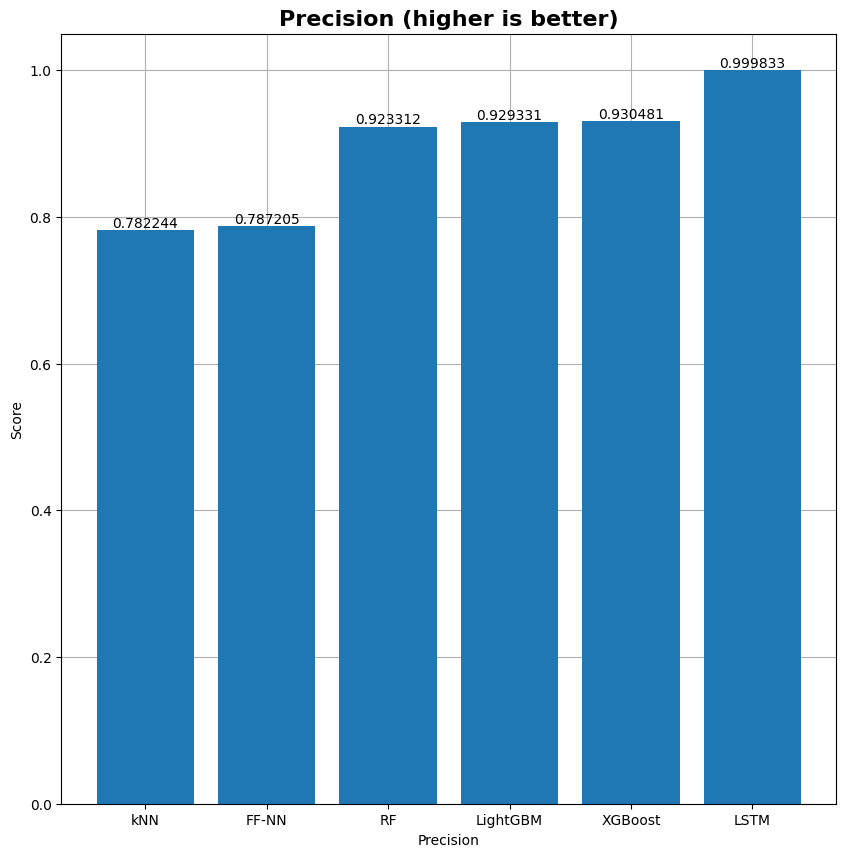

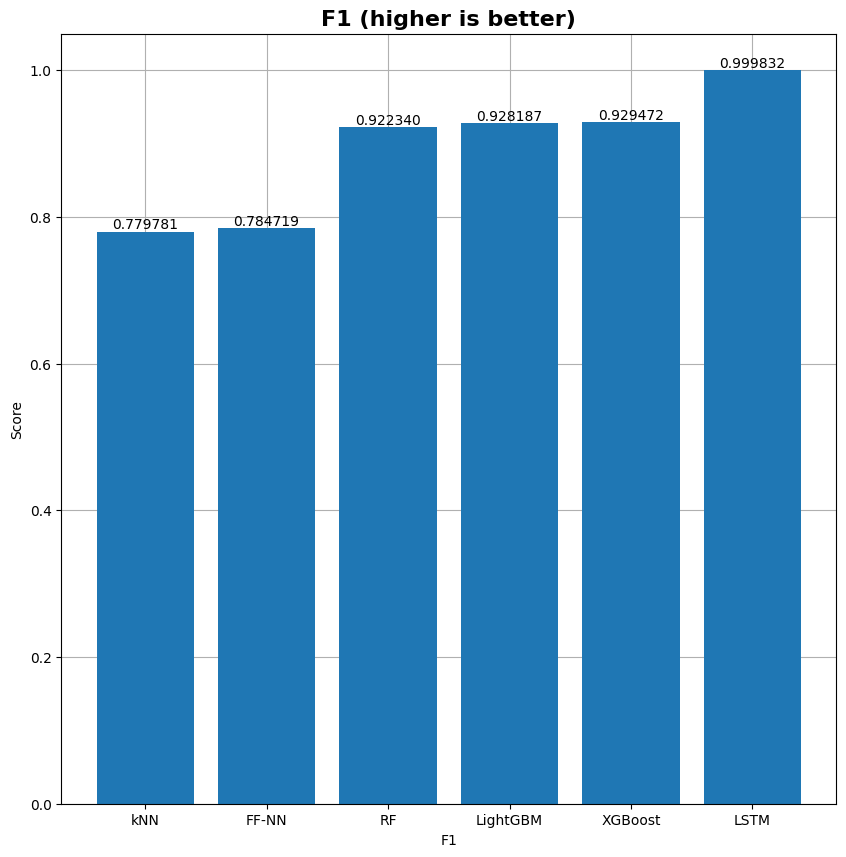

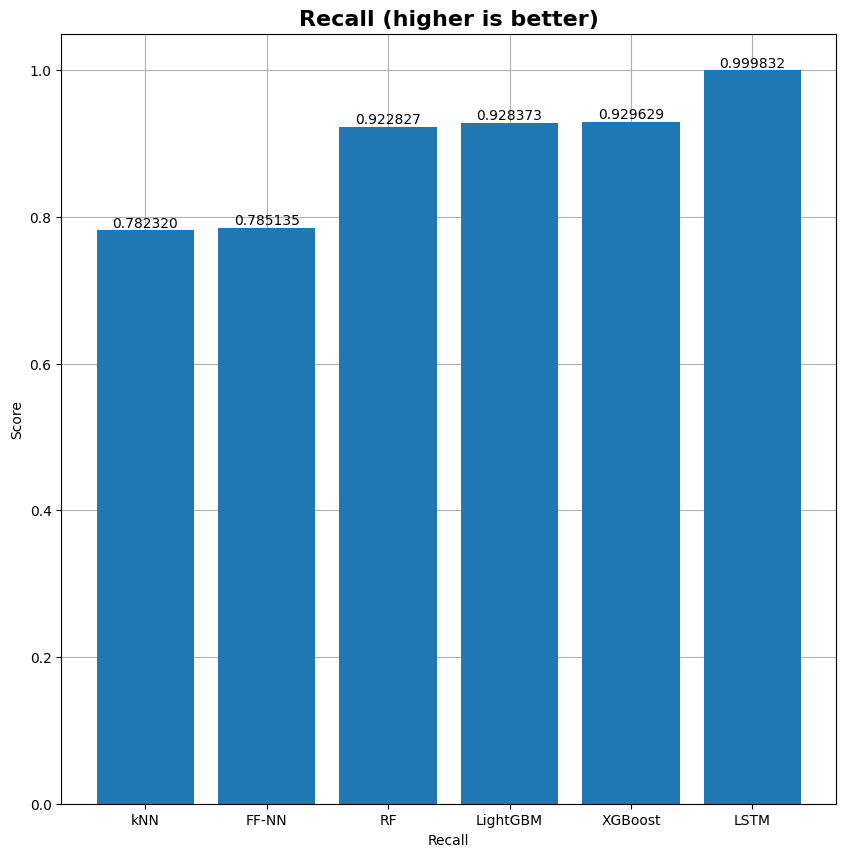

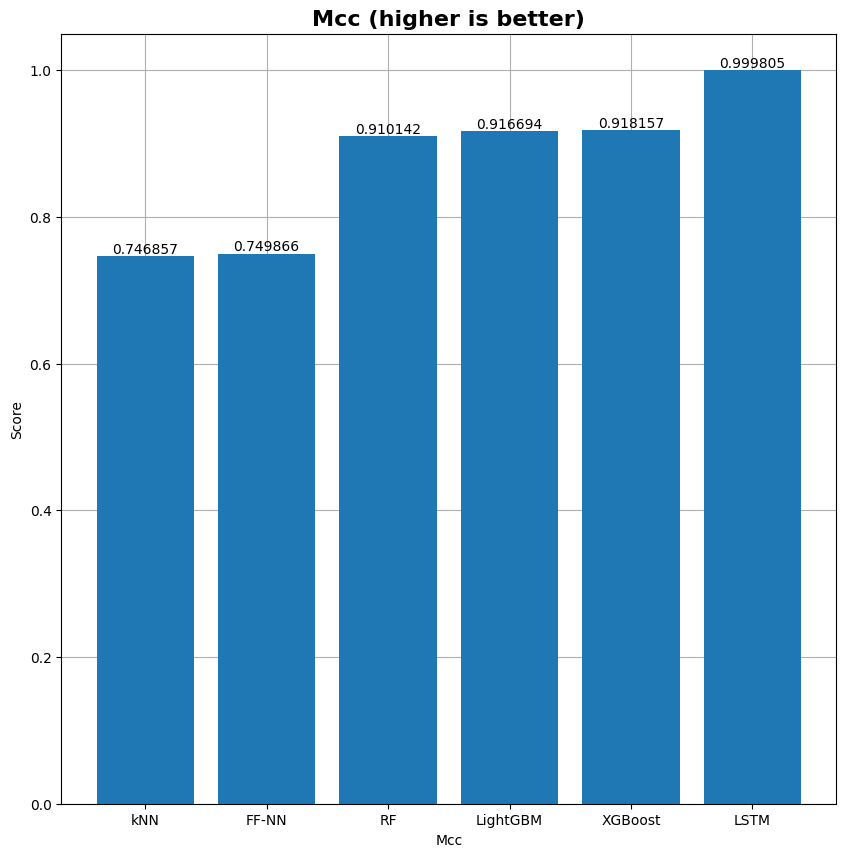

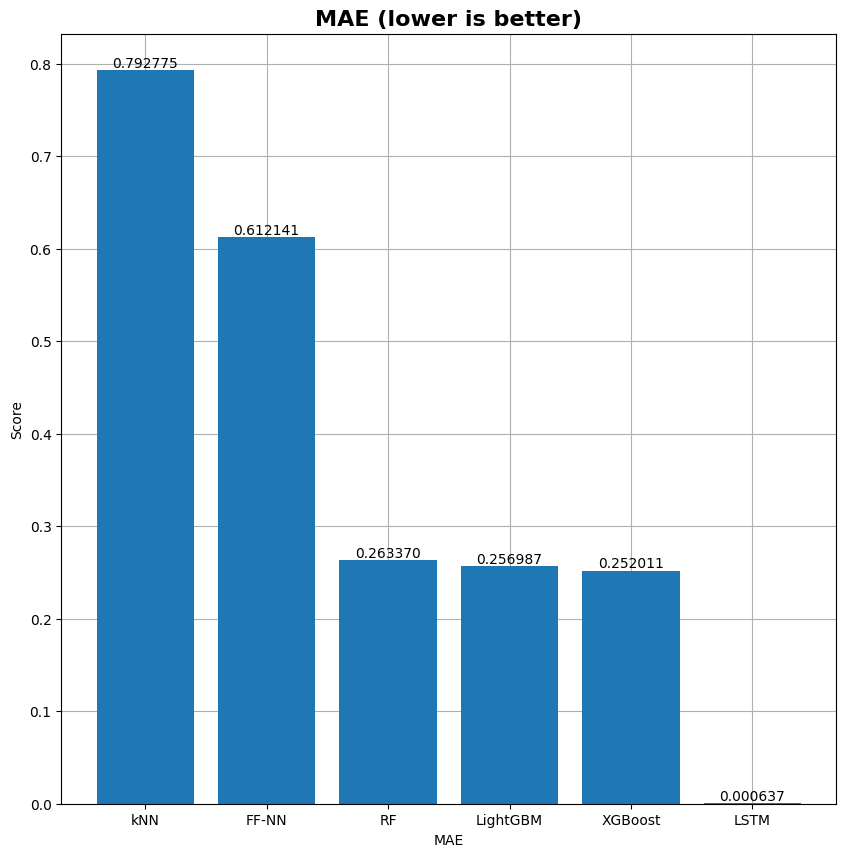

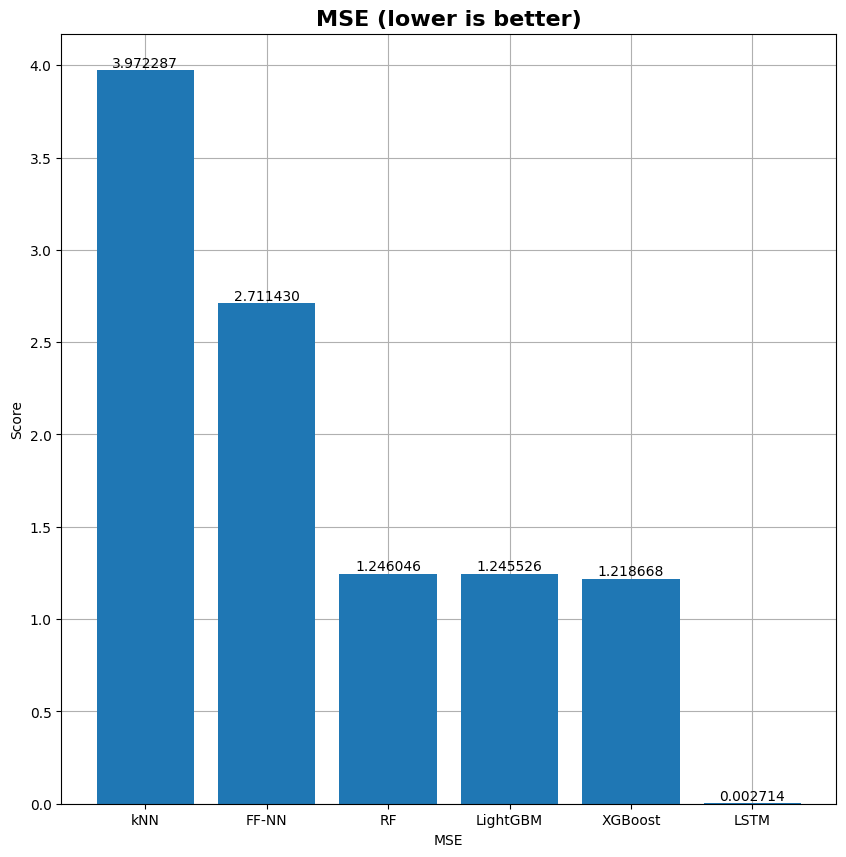

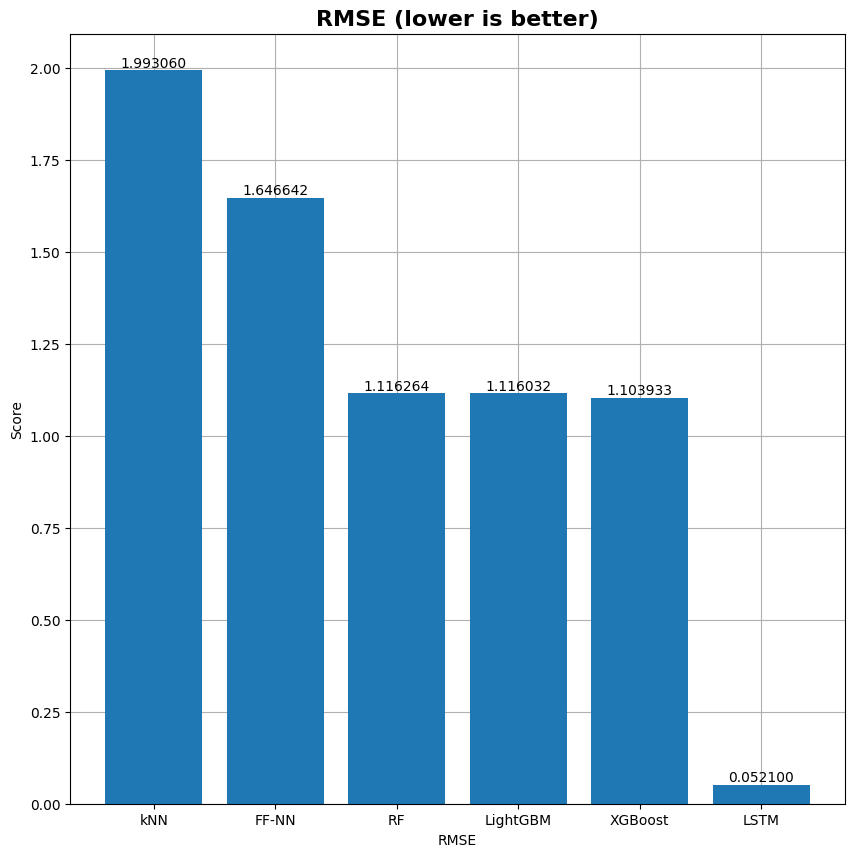

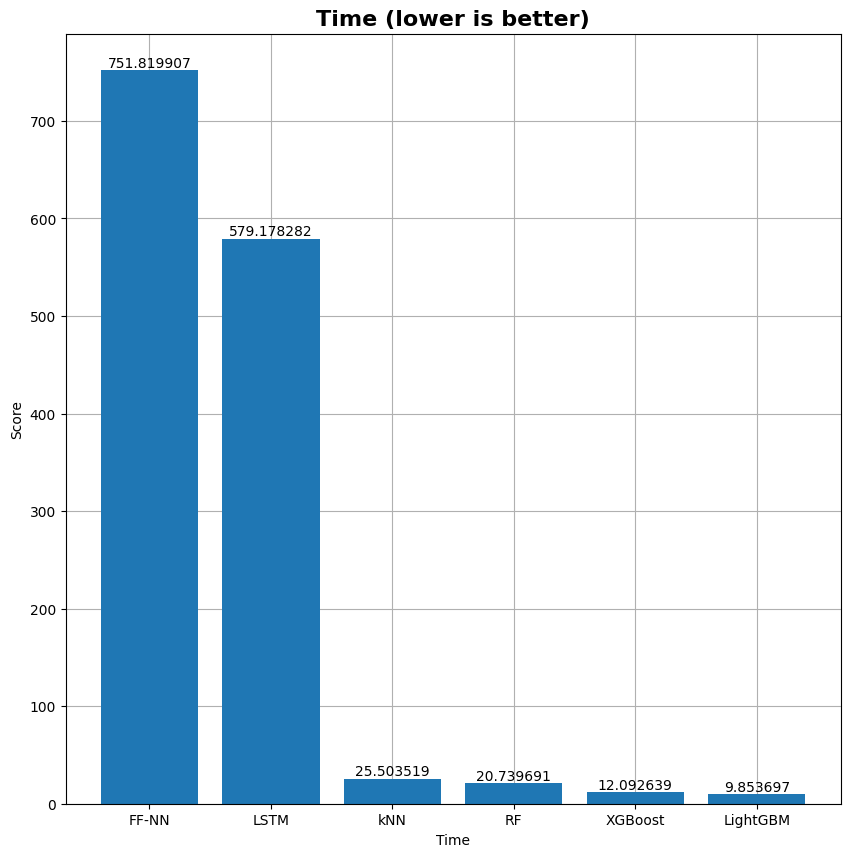

In [74]:
results_df = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MCC", "MAE", "MSE", "RMSE", "Time"])
for x in results_df:
    _dict = {}
    name = results_df[x].name
    for keys, values in zip(range(len(results_df[x].keys())), results_df[x]):
        _dict[results_df[x].keys()[keys]] = values
    result_plot(_dict, name, "multiclass", "")

# Save results dict

In [75]:
results_df.to_dict()

{'Accuracy': {'kNN': 0.7823202198244086,
  'RF': 0.9228268882782655,
  'XGBoost': 0.9296293814087527,
  'LightGBM': 0.9283727632196234,
  'FF-NN': 0.78513503074646,
  'LSTM': 0.9998324513435364},
 'Precision': {'kNN': 0.7822439300481392,
  'RF': 0.923312212492849,
  'XGBoost': 0.9304805498556283,
  'LightGBM': 0.9293305575183796,
  'FF-NN': 0.7872049591471866,
  'LSTM': 0.9998327162112927},
 'F1': {'kNN': 0.7797812857254756,
  'RF': 0.9223404590930815,
  'XGBoost': 0.9294723844762846,
  'LightGBM': 0.9281869558813103,
  'FF-NN': 0.7847189162910897,
  'LSTM': 0.9998324835124185},
 'Recall': {'kNN': 0.7823202198244086,
  'RF': 0.9228268882782655,
  'XGBoost': 0.9296293814087527,
  'LightGBM': 0.9283727632196234,
  'FF-NN': 0.7851350445680585,
  'LSTM': 0.9998324424858833},
 'MCC': {'kNN': 0.7468574665050342,
  'RF': 0.9101418794788991,
  'XGBoost': 0.9181567322640128,
  'LightGBM': 0.9166939856530298,
  'FF-NN': 0.7498660097728683,
  'LSTM': 0.9998049711946702},
 'MAE': {'kNN': 0.7927752